# Collecting data from multiple Stock forums to understand and quantify when does a group behoviour pattern can result in major deviation from the expected trends in the stock market  and result in a stock becoming a meme stock.

#### Name: Venkatesh Manikantan          Date: 01/08/2021

Introdution:

The inspiration to collect data from reddit to understand collective behovaiour of people in a community comes from the incident which took place with the gamestop stocks value earlier this year.

The challange is to identify group and forum behaviour which leads to solidarity in the behaviour of multiple induviduals in the market at a purticular time.

Task:
1) Scrape from reddit succesfully
2) Enable word_to_vec
3) Anlayze the words 
4) Form conclusions on the next steps


Conclusion:

Due to the nature of the data which was scraped, I felt that it would not benfit to set up a perdcitive tool with a randomforrest to predict the volume of stock trade with respect to the vector of words compresed to a day.

This is beacause from the intial runs of setting up a local word_to_vec platform could not produce significant genralization. I took top 100 post from the top reddit site which resulted in a total datavalues of over 90,000 values.

To solve this issue, we have to perform transfer learning from the google word_to_vec tool and retrain the weights. 
and also a lot more of the reddit channels needs to be scraped, both containing news on stock of meme and normal stocks.


The use case :-

When a large enough community data is collected then with clustering with respect to those communities, it can be indentified if any new online community is showing similar signs with respect to stocks to a meme stock community.
if such a process is developed with streaming data, it could prove valuable.


What did I achive :-

A) Built a decent enough scraping functions to scrape any number comments from the post including the reply trees 
B) Did a clustering analysis with T-SNE to understand the spread of stock related words in the GME stock community 

The valuable lesson to be learned here is, the task to indentify communities requires to scrape an enormous amount of data.


Improvemnts and future:-

1) should look into enable transfer learning to genralize even better 
2) Need to setup more scraping of diffrent information containing information on a stock
3) To setup jump and drop in stocks as categorical data in order to find if there is a clear descion boundries between them  


### Data collection/handeling Libraries 


In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import requests 
import yfinance as yf
import selenium
from bs4 import BeautifulSoup
import praw

### Supporting Libraries 

In [2]:
import datetime as dt

### Config files 

In [3]:
import reddit_config as r_cnf

### Data analysis libraries 

In [4]:
from afinn import Afinn
from sklearn.feature_extraction.text import CountVectorizer

### Data Visualization Libraries 

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy 

### Word_to_vec 

In [148]:
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from random import choices
from time import time
import gensim 
from gensim.models import KeyedVectors

## Part 1 - Collecting Data :- Stock market data followed by forum data 

#### Yahoo Finance Fixed library is used to aquire historical stock market data

In [6]:
def get_stock_data(stock_name, time_range): #Name of the stock - input string , Time range - yyyy-mm-dd - input string
    yf.pdr_override()
    Stock = pdr.get_data_yahoo(stock_name, start=time_range)                                         
    return Stock 


In [7]:
GME_data = get_stock_data('GME','2020-01-01')
GME_data1 = pd.DataFrame(data= GME_data)
GME_data1 = GME_data1.drop(['Volume'], axis=1)
GME_data1.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-31,6.08,6.39,5.99,6.08,6.08
2020-01-02,6.14,6.47,6.07,6.31,6.31
2020-01-03,6.21,6.25,5.84,5.88,5.88
2020-01-06,5.80,5.91,5.60,5.85,5.85
2020-01-07,5.77,5.83,5.44,5.52,5.52


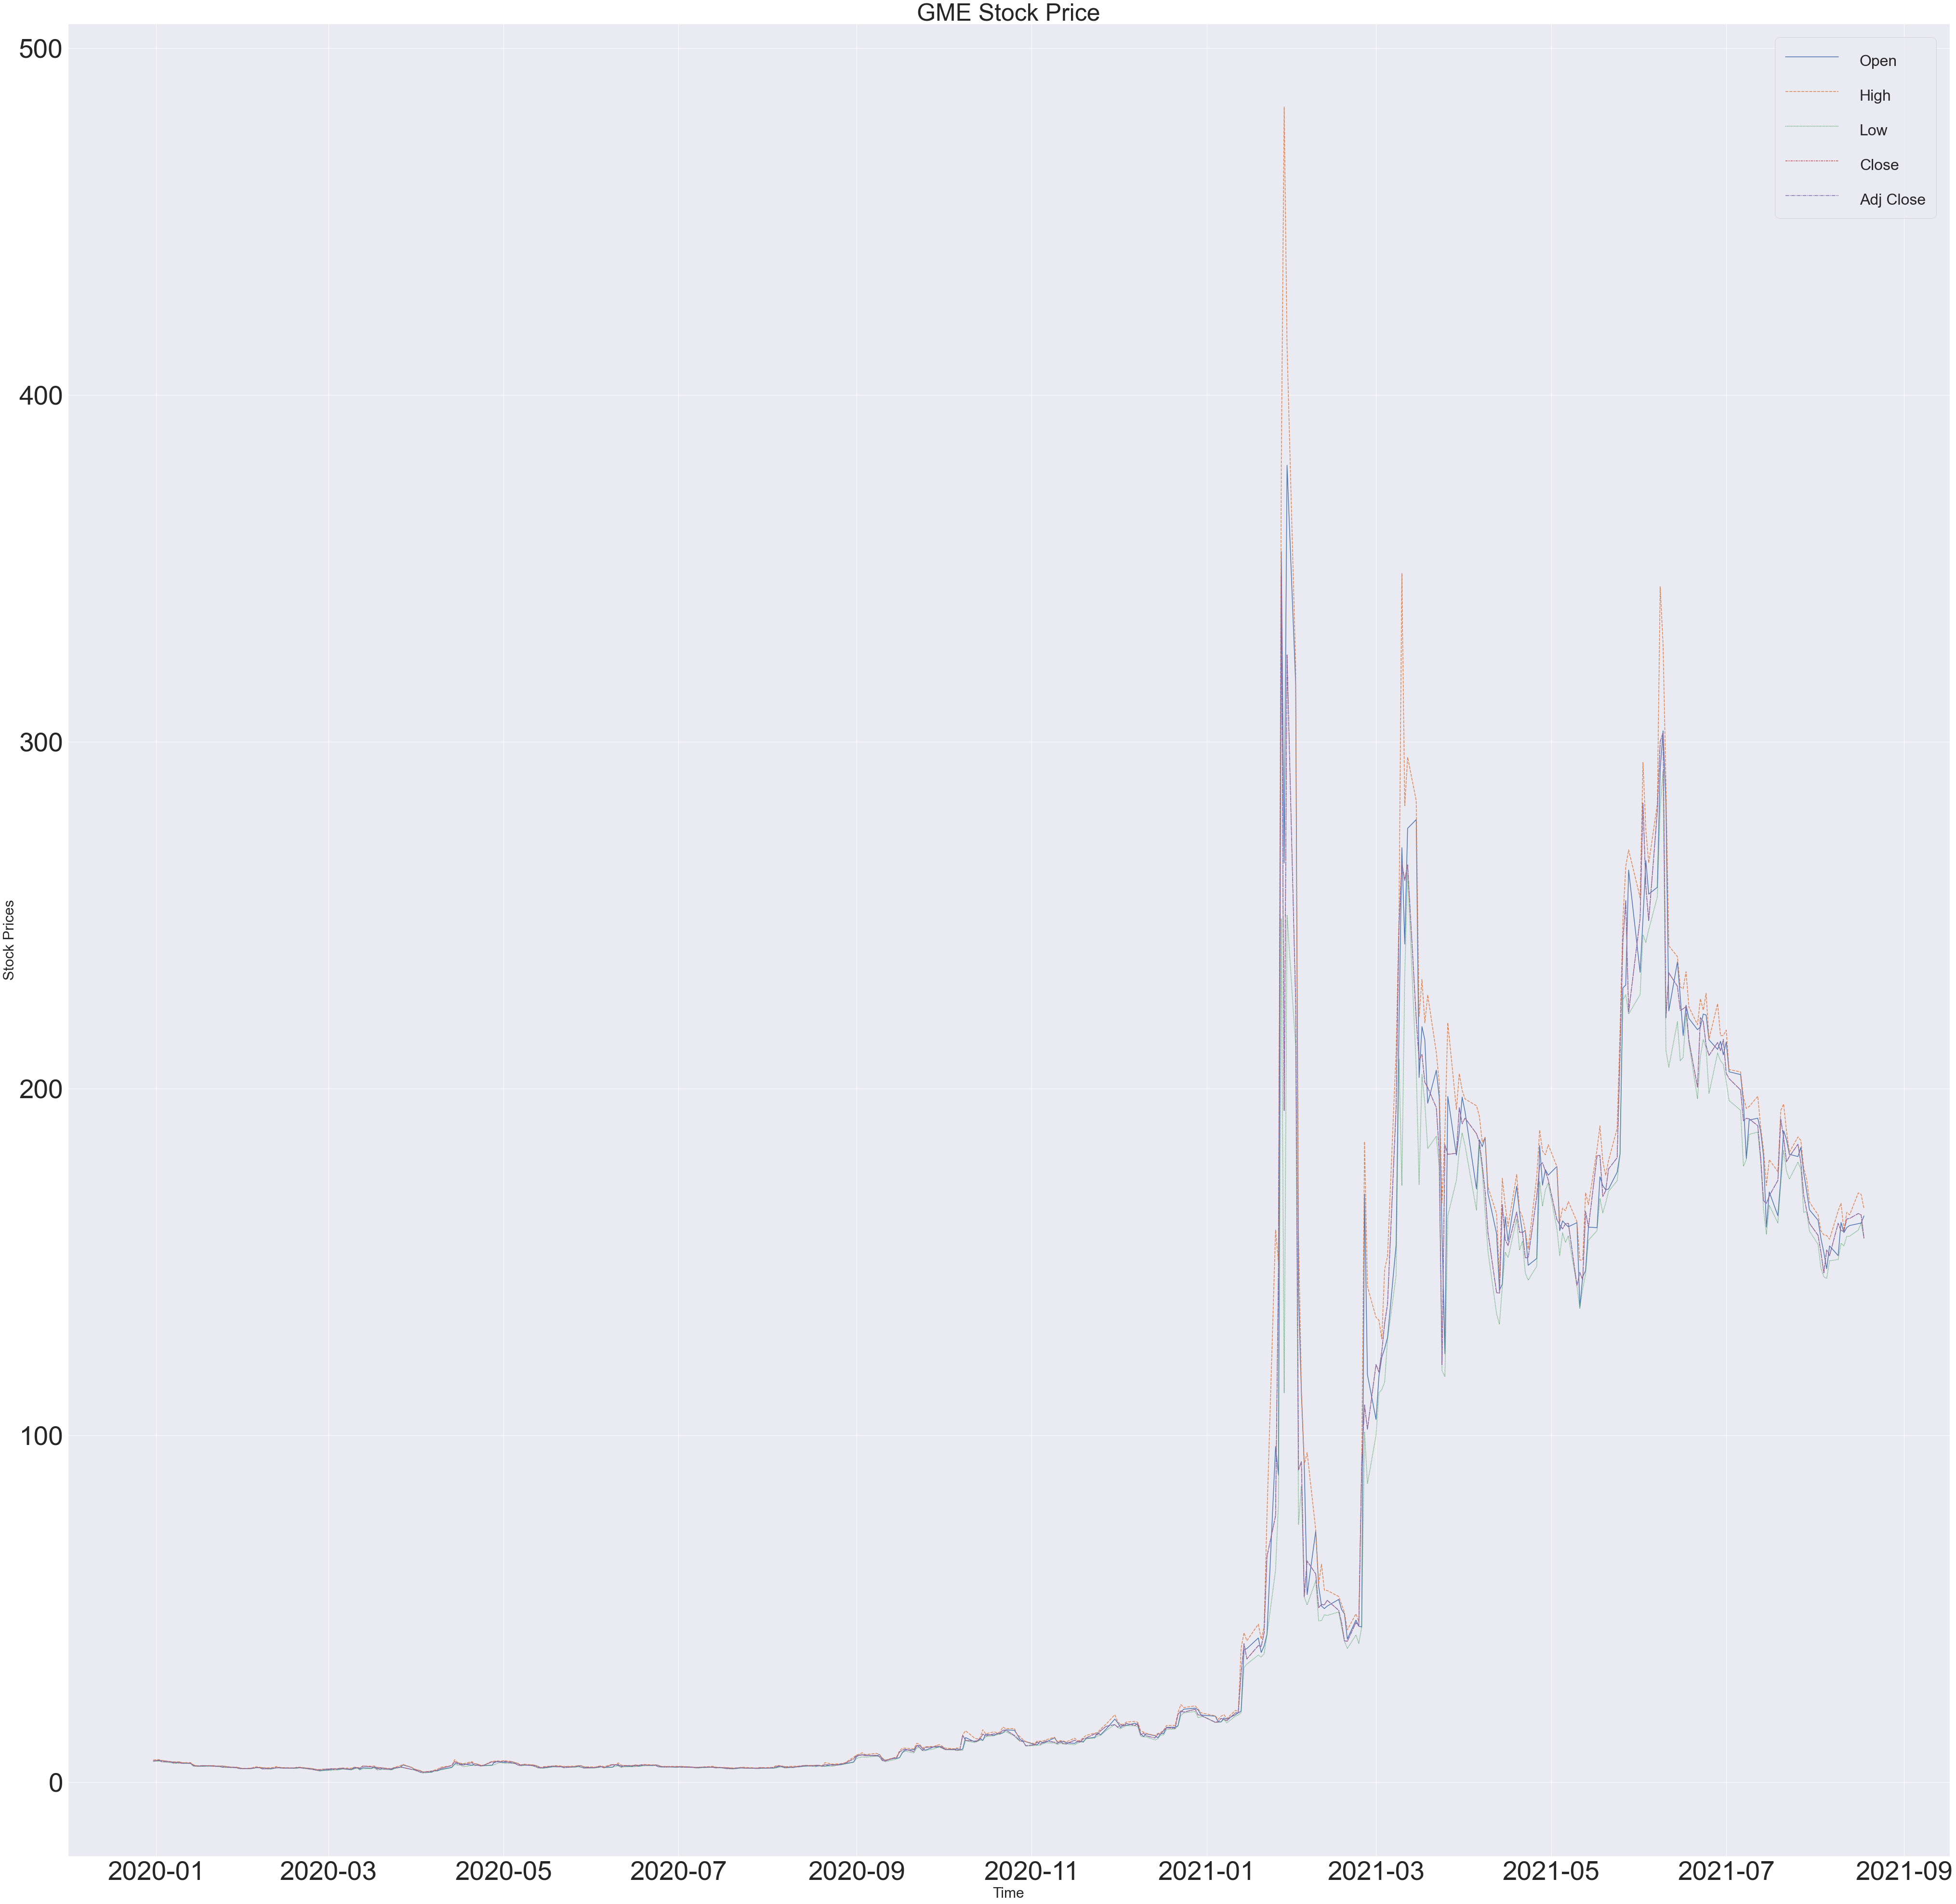

In [8]:
plt.figure(figsize=(70, 70))
sns.set(font_scale=5)
ax = sns.lineplot(data= GME_data1)
ax.axes.set_title("GME Stock Price",fontsize=50)
ax.set_xlabel("Time",fontsize=30)
ax.set_ylabel("Stock Prices",fontsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='32') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')
plt.show()

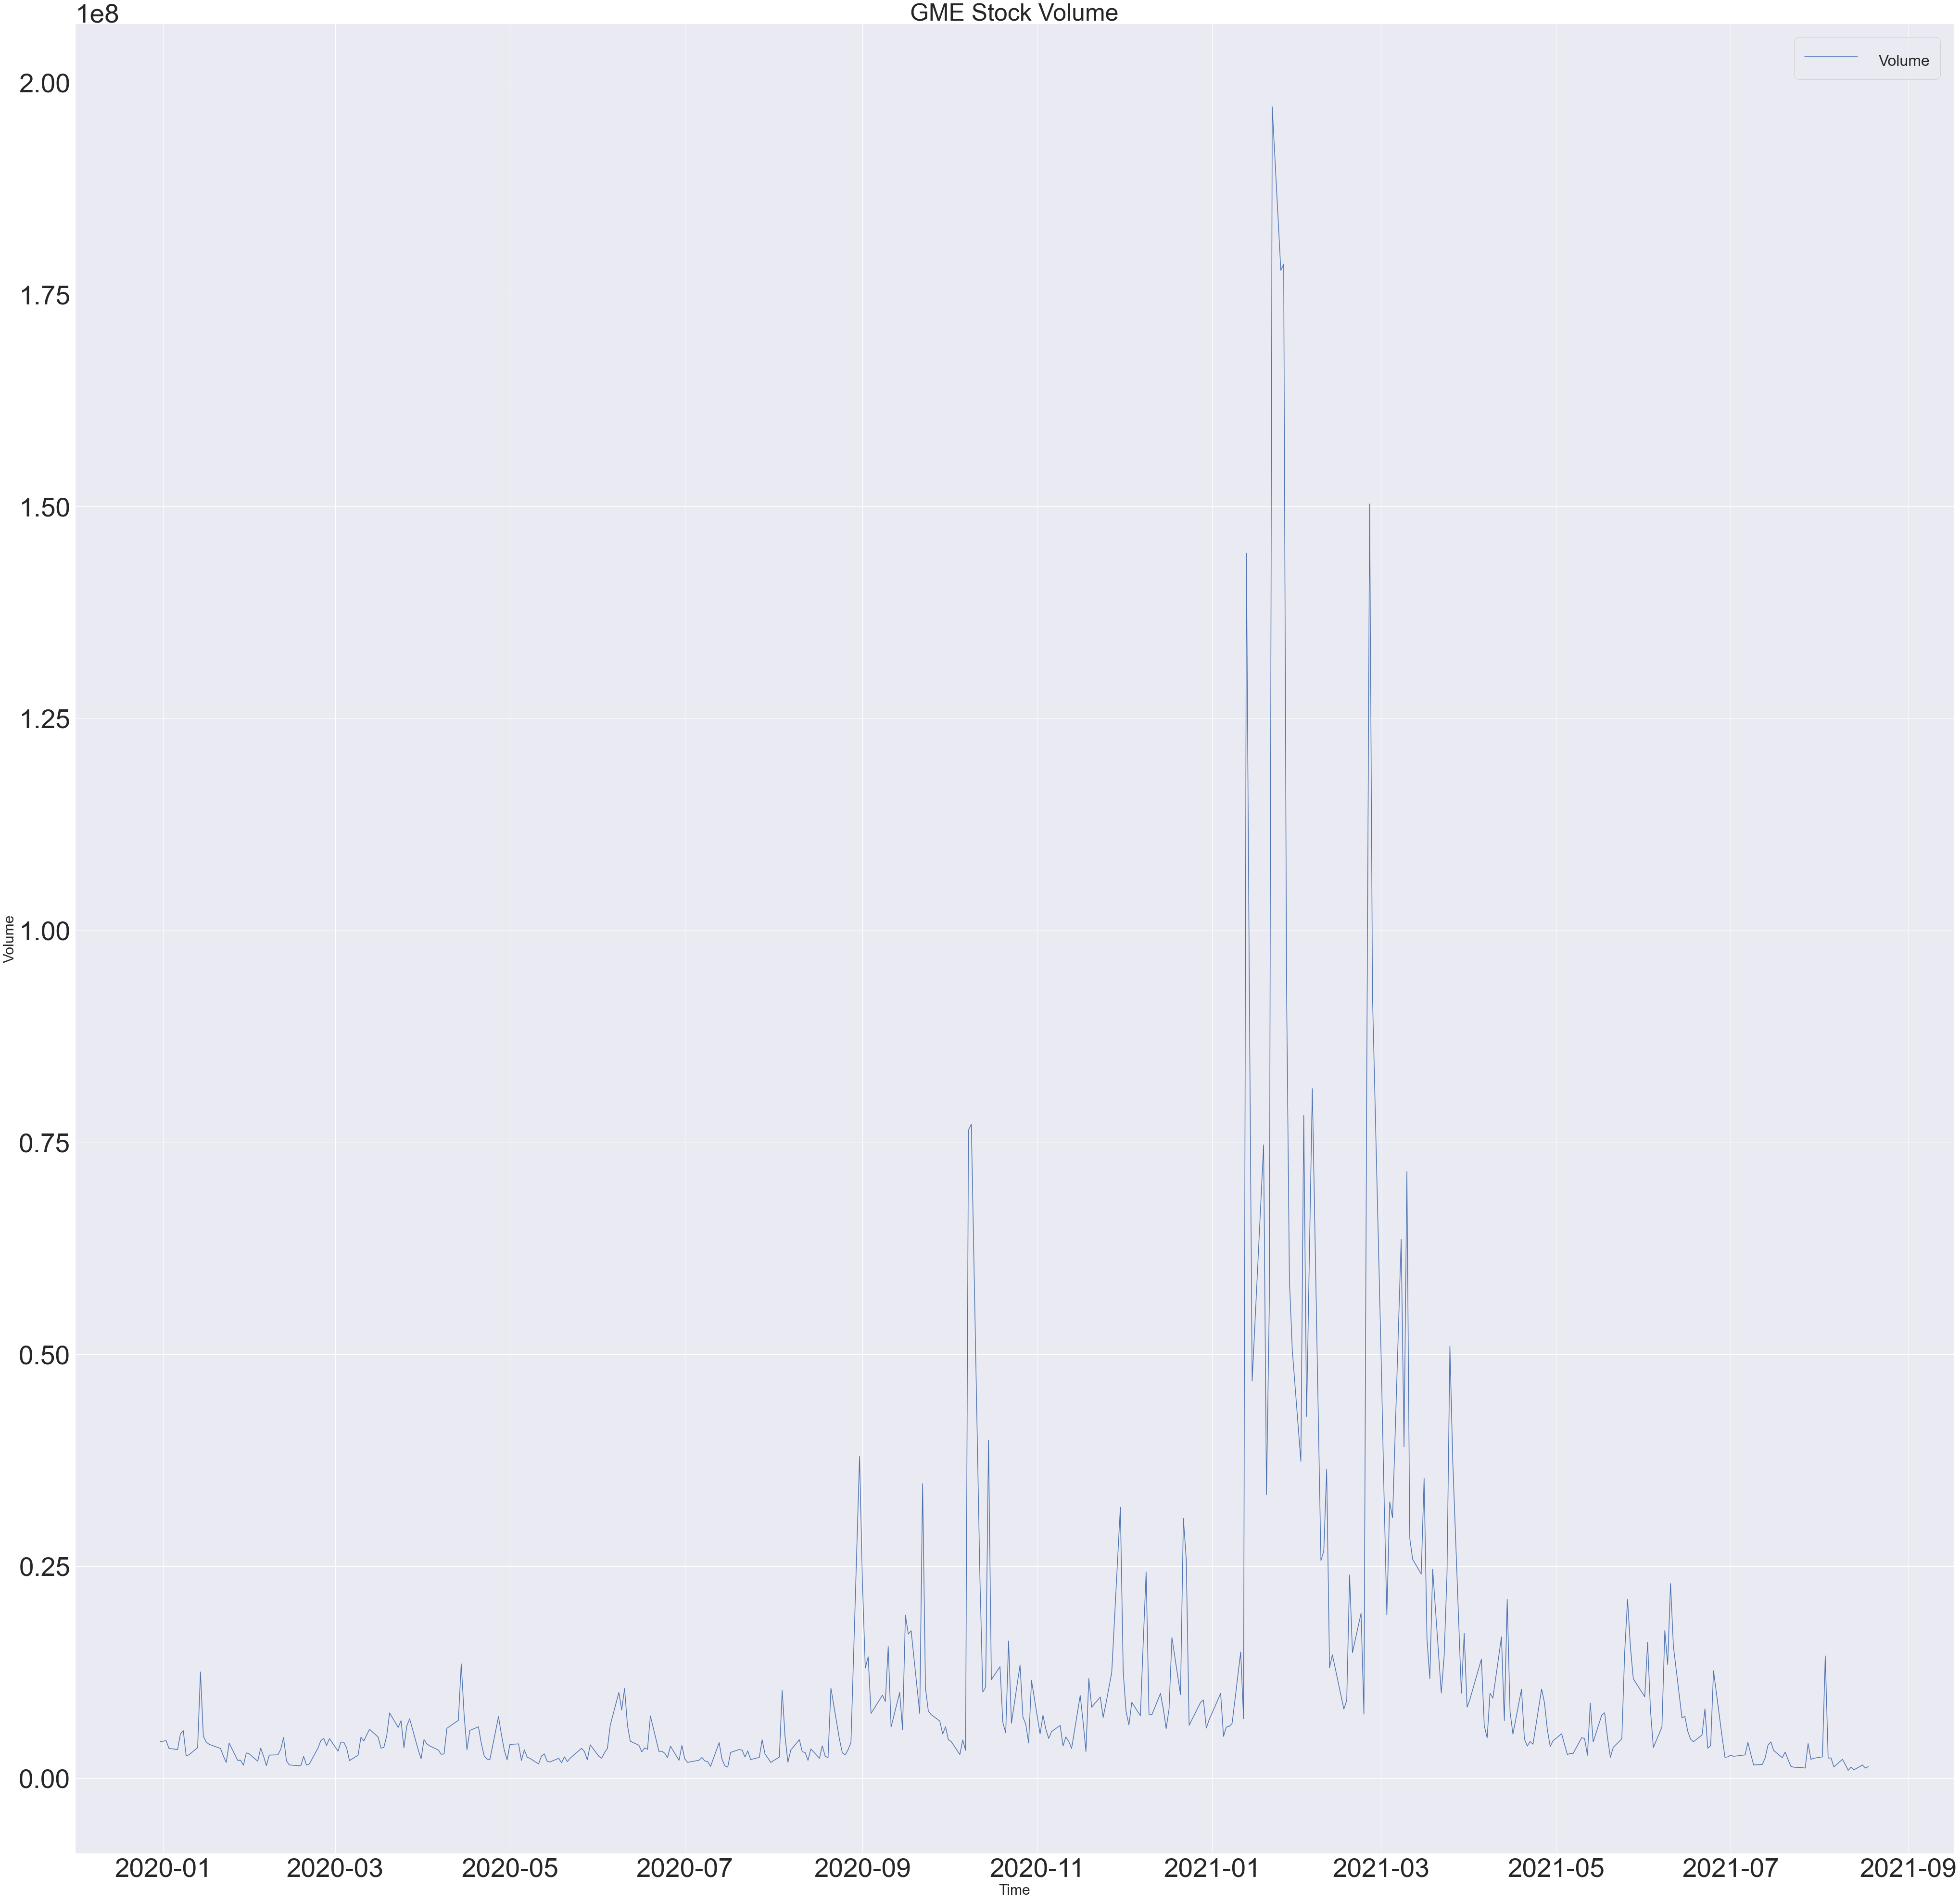

In [9]:
GME_dataV = pd.DataFrame(data= GME_data)
GME_dataV = GME_dataV.drop(['Open','High','Low','Close','Adj Close'], axis=1)
plt.figure(figsize=(70, 70))
sns.set(font_scale=5)
ax = sns.lineplot(data= GME_dataV)
ax.axes.set_title("GME Stock Volume",fontsize=50)
ax.set_xlabel("Time",fontsize=30)
ax.set_ylabel("Volume",fontsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='32') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')
plt.show()

#### Showcasing the artificial demand  created for the GME (Game stop) stocks 

The graph above showcases the events that took place earlier this year from the end of January  till the end of February,where a large group of induviduals coordinated together on online forums to disrupt the attempt of hedge funds to short the stock of GME. 

It is quite evident that these hedge funds never considered such solidarity from induvidual market players to come together in order to hold on to the stocks, which created an inverse demand as the firms that shorted the stock were in dire need to buy them back.

The crux of the matter is the risk models used by such firms never considered the fluctuation which could be created by such forums until the effect of the coordinated effort and the spread of information is already showing its impact on the market, as induviduals have started following a horde/group mentality.

The idea is to explore if the data collected from diffrent sources such as forums, twitter and other channels such as news could be useful in identifying when a group starts to behave in unision.

And when a stock is proppeled by the influence of social media it is kown as a MEME stock. 

### Collecting text data from Gamestop subreddit forum  

#### Collecting Data from Reddit forums  

In [10]:
reddit = praw.Reddit(client_id='AVu7k513AHb_DSBUp3GPPg', \
                     client_secret='YtLs8QTniQRUZHxjCL1_uUsdvMPiyA', \
                     user_agent='CABD', \
                     username= r_cnf.reddit['accessCode'] , \
                     password= r_cnf.reddit['secretCode'] )

##### Extracting top subreddits posts 

In [46]:
GME_subreddit = reddit.subreddit('Gamestopstock')
top_subreddit = GME_subreddit.top(limit=1000)
Subreddit_dict = { "title":[],\
                "score":[],\
                "id":[],\
                "url":[],\
                "comms_num": [],\
                "created": [],\
                "body":[]}
for submission in top_subreddit:
    Subreddit_dict["title"].append(submission.title)
    Subreddit_dict["score"].append(submission.score)
    Subreddit_dict["id"].append(submission.id)
    Subreddit_dict["url"].append(submission.url)
    Subreddit_dict["comms_num"].append(submission.num_comments)
    Subreddit_dict["created"].append(submission.created)
    Subreddit_dict["body"].append(submission.selftext)

Subreddit_data = pd.DataFrame(Subreddit_dict)
Subreddit_top_com_id = { "id":[] }
Top_comm_posts = Subreddit_data['comms_num'].nlargest(n=5)
Top_comm_posts.index
for index in Top_comm_posts.index:
    Subreddit_top_com_id["id"].append(Subreddit_data.iloc[index]['id'])
Subreddit_top_com_id["id"]
Top_comm_posts

57    611
8     449
17    199
0     198
60    134
Name: comms_num, dtype: int64

##### Formating the created date to concat with the stock price data  

In [12]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

_timestamp = Subreddit_data["created"].apply(get_date)
Subreddit_data = Subreddit_data.assign(timestamp = _timestamp)
Subreddit_data = Subreddit_data.drop(['created'], axis=1)
Subreddit_data

,title,score,id,url,comms_num,body,timestamp
0,BUY and Ffffffffing HOLD YOU retards GME 101,147,l79yzo,https://www.reddit.com/r/Gamestopstock/comment...,198,# Buy GME this battle is far from over!!\n\n\n...,2021-01-28 22:50:03
1,Shareholder💎🙌🚀,104,meulgv,https://i.redd.it/oh1qi5z27pp61.jpg,25,,2021-03-28 06:38:31
2,Mmhhmmm,87,l8efek,https://i.redd.it/796j1oz2kee61.jpg,5,,2021-01-30 06:06:17
3,Hold!,66,nv5isk,https://i.redd.it/2gh70bunz1471.gif,16,,2021-06-08 16:37:55
4,Female fellow ape here! Pleeeease HODL until w...,63,m210re,https://www.reddit.com/r/Gamestopstock/comment...,21,,2021-03-10 17:11:23
...,...,...,...,...,...,...,...
900,HA HA HA!! ITS OVER YALL BEEN PLAYED ! HAHAHAHA,0,mcc48t,https://www.reddit.com/r/Gamestopstock/comment...,11,ITS FUNNY HOW BEFORE THE 2nd squeeze ON MARCH ...,2021-03-24 18:56:46
901,HAHAHAHA WHAT HAPPENED TO THE $800 ON MARCH 19...,0,m8q5mz,https://www.reddit.com/r/Gamestopstock/comment...,4,,2021-03-19 21:23:08
902,Sell GameStop. It is going nowhere and will pr...,0,lid0jx,https://www.reddit.com/r/Gamestopstock/comment...,10,,2021-02-12 16:14:50
903,Just sell. this mf going down under,0,mwwdsp,https://www.reddit.com/r/Gamestopstock/comment...,3,Just sell this mf is going down under🙄,2021-04-23 16:22:49


In [47]:
Subreddit_data.loc[[57]]

,title,score,id,url,comms_num,created,body
57,Hold hold hold. Where do you think this is gon...,30,m21x0c,https://www.reddit.com/r/Gamestopstock/comment...,611,1.615395e+09,


#### Extracting comments from a subreddit post

In [13]:
post = reddit.submission(id='l79yzo')



Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "body":[]}

for comment in post.comments:
    Subreddit_com_dict["score"].append(comment.score)
    Subreddit_com_dict["id"].append(comment.id)
    Subreddit_com_dict["created"].append(comment.created)
    Subreddit_com_dict["body"].append(comment.body)

Subreddit_com_data = pd.DataFrame(Subreddit_com_dict)
_timestamp = Subreddit_com_data["created"].apply(get_date)
Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
Subreddit_com_data = Subreddit_com_data.drop(['created'], axis=1)
Subreddit_com_data

,score,id,body,timestamp
0,5,goqkwur,"Guys I just bought, a lil late but whatever. L...",2021-02-25 19:55:36
1,4,goqryfo,Just bought 4 shares. Lets BUY AND HOLD!!!!!,2021-02-25 20:40:36
2,4,gordjt7,We holding tor tomorrow too friday ending high...,2021-02-25 23:08:59
3,4,gopug7i,Are we going to hit 400 today?,2021-02-25 16:59:59
4,3,gl5npue,You guys are crazy but smart stupid lmao you g...,2021-01-28 23:30:20
...,...,...,...,...
89,1,gop2tbe,Count down in 2.5hrs. Lets make this happen to...,2021-02-25 12:59:33
90,1,goqiddl,Next peek befor close of business... Est 320,2021-02-25 19:40:37
91,1,gor9wvp,"I live in Croatia,does Fidelity allow me buyin...",2021-02-25 22:42:49
92,1,gpasy8h,400$🎯,2021-03-01 15:07:49


#### Extracting reply from all the comments from a top post.

In [14]:
Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }


for comment in post.comments:
    Subreddit_com_dict["score"].append(comment.score)
    Subreddit_com_dict["id"].append(comment.id)
    Subreddit_com_dict["created"].append(comment.created)
    Subreddit_com_dict["com_body"].append(comment.body)
    for reply in comment.replies:
          Subreddit_com_dict["comm_tier1"].append(reply.body)
          for reply2 in reply.replies:
                  Subreddit_com_dict["comm_tier2"].append(reply2.body)

Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
_timestamp = Subreddit_com_data["created"].apply(get_date)
Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
Subreddit_com_data = Subreddit_com_data.drop(['created'], axis=1)
Subreddit_com_data

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,5,goqkwur,"Guys I just bought, a lil late but whatever. L...",289 is the number for the day. Let's see if th...,Yes there is im hearing 1000 as well,2021-02-25 19:55:36
1,4,goqryfo,Just bought 4 shares. Lets BUY AND HOLD!!!!!,i hope,"189, apologize.",2021-02-25 20:40:36
2,4,gordjt7,We holding tor tomorrow too friday ending high...,F' em. They've been grouping up and manipulati...,i hope,2021-02-25 23:08:59
3,4,gopug7i,Are we going to hit 400 today?,I don't know if they are dems but **** them,Ok Boss 😂\nWhat platforms do you trade on ?,2021-02-25 16:59:59
4,3,gl5npue,You guys are crazy but smart stupid lmao you g...,Offcourse you hold my beautiful retard,Thanks guys. I just bought 5 new stocks 😁,2021-01-28 23:30:20
...,...,...,...,...,...,...
89,1,gop2tbe,Count down in 2.5hrs. Lets make this happen to...,None,None,2021-02-25 12:59:33
90,1,goqiddl,Next peek befor close of business... Est 320,None,None,2021-02-25 19:40:37
91,1,gor9wvp,"I live in Croatia,does Fidelity allow me buyin...",None,None,2021-02-25 22:42:49
92,1,gpasy8h,400$🎯,None,None,2021-03-01 15:07:49


#### Progress so far:


### 1] Streamlining reddit comment and two tiers replies extraction with a fuction 

In [91]:
def extract_reddit_post_com_rep(subreddit_name): # Subreddit_name = String 
    import reddit_config as r_cnf # setup your config page - for username and password for your respective reddit account
    #Setting up a reddit model
    reddit = praw.Reddit(client_id='AVu7k513AHb_DSBUp3GPPg', \
                     client_secret='YtLs8QTniQRUZHxjCL1_uUsdvMPiyA', \
                     user_agent='CABD', \
                     username= r_cnf.reddit['accessCode'] , \
                     password= r_cnf.reddit['secretCode'] )
    try:
        GME_subreddit = reddit.subreddit(subreddit_name)
    except:
        print("Error in passing subreddit_name value")
    
    top_subreddit = GME_subreddit.top(limit=1000)
    Subreddit_dict = { "title":[],\
                "score":[],\
                "id":[],\
                "url":[],\
                "comms_num": [],\
                "created": [],\
                "body":[]}
    for submission in top_subreddit:
        Subreddit_dict["title"].append(submission.title)
        Subreddit_dict["score"].append(submission.score)
        Subreddit_dict["id"].append(submission.id)
        Subreddit_dict["url"].append(submission.url)
        Subreddit_dict["comms_num"].append(submission.num_comments)
        Subreddit_dict["created"].append(submission.created)
        Subreddit_dict["body"].append(submission.selftext)
    
    Subreddit_data = pd.DataFrame(Subreddit_dict)
    Subreddit_top_com_id = { "id":[] }
    Top_comm_posts = Subreddit_data['comms_num'].nlargest(n=6)
    for index in Top_comm_posts.index:
           Subreddit_top_com_id["id"].append(Subreddit_data.iloc[index]['id'])
    
    def get_date(created):
        return dt.datetime.fromtimestamp(created)

    _timestamp = Subreddit_data["created"].apply(get_date)
    Subreddit_data = Subreddit_data.assign(timestamp = _timestamp)
    Subreddit_data = Subreddit_data.drop(['created'], axis=1)
    # Top comment containeing reddit post's ID have been obtained 
    # Now to extract the 2 tier comment tree of these posts
    ######################################################No.1#########################################################
    post = reddit.submission(id=Subreddit_top_com_id["id"][0])
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }


    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                        continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    _timestamp = Subreddit_com_data["created"].apply(get_date)
    Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
    Subreddit_com_data_1 = Subreddit_com_data.drop(['created'], axis=1)
    
    ######################################################No.2#########################################################
    post = reddit.submission(id=Subreddit_top_com_id["id"][1])
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }


    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    
    try:
        _timestamp = Subreddit_com_data["created"].apply(get_date)
        Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
        Subreddit_com_data_2 = Subreddit_com_data.drop(['created'], axis=1)
    except:
        Subreddit_com_data_2 = Subreddit_com_data
        pass
    ######################################################No.3#########################################################
    post = reddit.submission(id=Subreddit_top_com_id["id"][2])
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }


    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    _timestamp = Subreddit_com_data["created"].apply(get_date)
    Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
    Subreddit_com_data_3 = Subreddit_com_data.drop(['created'], axis=1)
    ######################################################No.4#########################################################
    post = reddit.submission(id=Subreddit_top_com_id["id"][3])
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }
    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                        continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    _timestamp = Subreddit_com_data["created"].apply(get_date)
    Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
    Subreddit_com_data_4 = Subreddit_com_data.drop(['created'], axis=1)

    ######################################################No.5#########################################################
    post = reddit.submission(id=Subreddit_top_com_id["id"][4])
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }


    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                        continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    _timestamp = Subreddit_com_data["created"].apply(get_date)
    Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
    Subreddit_com_data_5= Subreddit_com_data.drop(['created'], axis=1)
    
    return Subreddit_data,Subreddit_com_data_1,Subreddit_com_data_2,Subreddit_com_data_3,Subreddit_com_data_4,Subreddit_com_data_5;
    

The above fucntion which takes a subreddit channel as an imput, returns a df containing all posts with respect to highest comment activity and scrapes these posts comments sections and reutrns other 5 dfs containing the comments and replies in the top 5 posts.

### Subreddit Channel : Gamestopstock - 9k members

In [16]:
Post_df,Comm_rep_tp1,Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5 = extract_reddit_post_com_rep('Gamestopstock')

In [17]:
Post_df

,title,score,id,url,comms_num,body,timestamp
0,BUY and Ffffffffing HOLD YOU retards GME 101,149,l79yzo,https://www.reddit.com/r/Gamestopstock/comment...,198,# Buy GME this battle is far from over!!\n\n\n...,2021-01-28 22:50:03
1,Shareholder💎🙌🚀,107,meulgv,https://i.redd.it/oh1qi5z27pp61.jpg,25,,2021-03-28 06:38:31
2,Mmhhmmm,87,l8efek,https://i.redd.it/796j1oz2kee61.jpg,5,,2021-01-30 06:06:17
3,Hold!,69,nv5isk,https://i.redd.it/2gh70bunz1471.gif,16,,2021-06-08 16:37:55
4,Female fellow ape here! Pleeeease HODL until w...,63,m210re,https://www.reddit.com/r/Gamestopstock/comment...,21,,2021-03-10 17:11:23
...,...,...,...,...,...,...,...
900,HA HA HA!! ITS OVER YALL BEEN PLAYED ! HAHAHAHA,0,mcc48t,https://www.reddit.com/r/Gamestopstock/comment...,11,ITS FUNNY HOW BEFORE THE 2nd squeeze ON MARCH ...,2021-03-24 18:56:46
901,HAHAHAHA WHAT HAPPENED TO THE $800 ON MARCH 19...,0,m8q5mz,https://www.reddit.com/r/Gamestopstock/comment...,4,,2021-03-19 21:23:08
902,Sell GameStop. It is going nowhere and will pr...,0,lid0jx,https://www.reddit.com/r/Gamestopstock/comment...,10,,2021-02-12 16:14:50
903,Just sell. this mf going down under,0,mwwdsp,https://www.reddit.com/r/Gamestopstock/comment...,3,Just sell this mf is going down under🙄,2021-04-23 16:22:49


In [18]:
Comm_rep_tp1

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,4,gorbxie,"Guys, just remember, WE'RE NOT FCKING LEAVING!...",We all are fcking retards that are never fckin...,Check my post blow by blow before it happens a...,2021-02-25 22:57:03
1,2,gorcphe,Hi. I own GME and AMC and i enjoyed here 1 mon...,"1, 10, 3000..... it all help the cause when he...",EXACTLY!,2021-02-25 23:02:41
2,2,gornbdz,And why are people posting about that on this ...,I used to be in this group but there seems to ...,That's true. But are some good guyz who can ma...,2021-02-26 00:23:53
3,1,gor7946,Why is gme falling so deep now?,Yeah why ?,Here's a sneak peek of /r/GME using the [top p...,2021-02-25 22:24:05
4,1,gor83nq,GME is being shorted to drive down the price ...,Thanks 🙏🏼,Yea shit ton of people are buying tomorrow,2021-02-25 22:30:02
...,...,...,...,...,...,...
392,1,gq8f8fm,They will remember GME! GME! GME!,None,None,2021-03-08 18:44:57
393,1,gq922sx,let's get it!,None,None,2021-03-08 21:28:08
394,1,gqavave,Im all in it to the very ends baby,None,None,2021-03-09 07:20:38
395,1,gqebmmg,"just got a new advisor, screw ML, never there ...",None,None,2021-03-10 02:24:11


In [19]:
##The timestamp function falied to work on the comments of this purticualar comment tree due to diffrent value type 
Comm_rep_tp2

,score,id,created,com_body,comm_tier1,comm_tier2
0,12,gm0pnjb,1612464218.0,💎 🙌,Hold the fcking line 🚀💎🙌🏻,"When it gets to 40, lets all buy again. Then s..."
1,11,gm0poly,1612464230.0,I'm holding.... I bout more actually!!!!!,💎✊🏻,The end is 0.0001
2,7,gm0sya8,1612465512.0,I am holding till the end,It's all good... this was profit money.. I hav...,40
3,7,gm0v8mb,1612466429.0,Holding 💎🙌,Bad idea unless you’re holding a short positio...,Making money was never the point
4,5,gm0w3ti,1612466776.0,Holdind Till the end,Lose money To make a statement that Has no i...,You Said Dell😂
5,4,gm18wxg,1612471933.0,Is anyone else nervous tho? :/ I have three sh...,When is “the end”? $1.00/share?,"Hold till it gets to 40, then buy"
6,4,gm12vqv,1612469520.0,HOLDING 👊,Bad idea if you are holding a long position. G...,"I already lost a lot of money in gme, so no se..."
7,3,gm14b8h,1612470108.0,Holding and supporting all the employees prayi...,Bad idea unless you don’t mind loosing what yo...,Nope not selling. I am in to own was from the...
8,3,gm17jz3,1612471391.0,Hold strong and buy strong!,"I am, bought 30 at $114 :(",I know. \nYou are bad idea!!!!!!! Dont comment...
9,3,gm19urg,1612472302.0,"Today on GME, we suffer, but think when the se...",When it gets down to about 40 buy more,"I would not play their game, if I wanted to do..."


In [20]:
Comm_rep_tp2.dtypes

score         object
id            object
created       object
com_body      object
comm_tier1    object
comm_tier2    object
dtype: object

In [21]:
Comm_rep_tp2["created"] = pd.to_numeric(Comm_rep_tp2["created"])


In [22]:
Comm_rep_tp2 = Comm_rep_tp2[Comm_rep_tp2['created'].notna()]


In [23]:
_timestamp = Comm_rep_tp2["created"].apply(get_date)
Comm_rep_tp2 = Comm_rep_tp2.assign(timestamp = _timestamp)
Comm_rep_tp2 = Comm_rep_tp2.drop(['created'], axis=1)
Comm_rep_tp2

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,12,gm0pnjb,💎 🙌,Hold the fcking line 🚀💎🙌🏻,"When it gets to 40, lets all buy again. Then s...",2021-02-04 19:43:38
1,11,gm0poly,I'm holding.... I bout more actually!!!!!,💎✊🏻,The end is 0.0001,2021-02-04 19:43:50
2,7,gm0sya8,I am holding till the end,It's all good... this was profit money.. I hav...,40,2021-02-04 20:05:12
3,7,gm0v8mb,Holding 💎🙌,Bad idea unless you’re holding a short positio...,Making money was never the point,2021-02-04 20:20:29
4,5,gm0w3ti,Holdind Till the end,Lose money To make a statement that Has no i...,You Said Dell😂,2021-02-04 20:26:16
5,4,gm18wxg,Is anyone else nervous tho? :/ I have three sh...,When is “the end”? $1.00/share?,"Hold till it gets to 40, then buy",2021-02-04 21:52:13
6,4,gm12vqv,HOLDING 👊,Bad idea if you are holding a long position. G...,"I already lost a lot of money in gme, so no se...",2021-02-04 21:12:00
7,3,gm14b8h,Holding and supporting all the employees prayi...,Bad idea unless you don’t mind loosing what yo...,Nope not selling. I am in to own was from the...,2021-02-04 21:21:48
8,3,gm17jz3,Hold strong and buy strong!,"I am, bought 30 at $114 :(",I know. \nYou are bad idea!!!!!!! Dont comment...,2021-02-04 21:43:11
9,3,gm19urg,"Today on GME, we suffer, but think when the se...",When it gets down to about 40 buy more,"I would not play their game, if I wanted to do...",2021-02-04 21:58:22


In [24]:
Comm_rep_tp3

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,4,goqkwur,"Guys I just bought, a lil late but whatever. L...",289 is the number for the day. Let's see if th...,Yes there is im hearing 1000 as well,2021-02-25 19:55:36
1,4,goqryfo,Just bought 4 shares. Lets BUY AND HOLD!!!!!,i hope,"189, apologize.",2021-02-25 20:40:36
2,6,gordjt7,We holding tor tomorrow too friday ending high...,F' em. They've been grouping up and manipulati...,i hope,2021-02-25 23:08:59
3,4,gopug7i,Are we going to hit 400 today?,I don't know if they are dems but **** them,Ok Boss 😂\nWhat platforms do you trade on ?,2021-02-25 16:59:59
4,3,gl5npue,You guys are crazy but smart stupid lmao you g...,Offcourse you hold my beautiful retard,Thanks guys. I just bought 5 new stocks 😁,2021-01-28 23:30:20
...,...,...,...,...,...,...
89,1,gop2tbe,Count down in 2.5hrs. Lets make this happen to...,None,None,2021-02-25 12:59:33
90,1,goqiddl,Next peek befor close of business... Est 320,None,None,2021-02-25 19:40:37
91,1,gor9wvp,"I live in Croatia,does Fidelity allow me buyin...",None,None,2021-02-25 22:42:49
92,1,gpasy8h,400$🎯,None,None,2021-03-01 15:07:49


In [25]:
Comm_rep_tp4

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,1,gl8y873,Hi i put money on silver 🚀🚀,It's in the FAQ,None,2021-01-29 16:43:54
1,1,gl8ys9c,How the fuck is SLV not being discussed all ov...,Yes,None,2021-01-29 16:47:14
2,1,gl8yyt1,IT IS,What makes you say that?,None,2021-01-29 16:48:19
3,1,gl8z0pd,But it's snowing under due GME,Yes yes yes!!!,None,2021-01-29 16:48:38
4,1,gl90gt6,SLV being manipulated for decades,"**mmhmm called mobicard, the app is.** \n\n*-c...",None,2021-01-29 16:57:09
...,...,...,...,...,...,...
115,1,glekpp4,Are people leave Robinhood platform?,None,None,2021-01-30 21:32:50
116,1,glgt6b3,SGL Carbon is a Big short seller,None,None,2021-01-31 10:47:31
117,1,glmzh60,Silvercorp metals,None,None,2021-02-01 20:31:53
118,1,gln18bh,Yes SVM,None,None,2021-02-01 20:43:22


In [26]:
Comm_rep_tp5

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,3,gouyq90,The hedge fund guys are playing defense .. the...,None,None,2021-02-26 19:07:45
1,3,gouzozm,just have to hold no paper hands,None,None,2021-02-26 19:12:07
2,2,gougacw,"Don’t look at it as getting rich, but making a...",None,None,2021-02-26 17:42:22
3,1,gou3xmq,We are headed the wrong direction for $1000,None,None,2021-02-26 16:11:59
4,1,gou3zpf,buy buy buy,None,None,2021-02-26 16:12:26
...,...,...,...,...,...,...
117,1,goxavc5,bitcoin is going to the moon,None,None,2021-02-27 02:52:50
118,1,goxlq6c,I'm down also. hope it goes back up,None,None,2021-02-27 04:14:43
119,1,gp0px4u,If you guys are on this sub you also need to b...,None,None,2021-02-27 16:30:07
120,1,gp6bkh4,Buy or sell?,None,None,2021-02-28 15:46:39


#### Review of the performance of the fuction  

The fuction showcased above tries to package the collection of comments and posts data from reddit. Though it can be noticed that the function is working as intended in the above case, there are still some issues that can arise and needs to be compensated.
1) Post in a reddit page is of two types,                                                                                 
a) a live discussion post                                                                                                 
b) a static post.                                                                                                         

In the above case live discussion posts are not able to be scrapped and therefore a method needs to be developed to identify and scrape them.                                                                                                    
2) Some of the posts have a change in thier created variables and therefore for a small minority of post other methods to capture the time created needs to be built.

3) Function could be made more robust to take care of other errors which could arise and make it more user friendly, such as Nan's in the created collumn of the df which can impact the timestamp function 

#### Merging and grouping with respect to date - In order to compare with stock price date  

In [44]:
Comm_all_GME = pd.concat([Comm_rep_tp1, Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5], ignore_index=True)
Comm_all_GME
cols = ['com_body','comm_tier1', 'comm_tier2']
Comm_all_GME['combined'] = Comm_all_GME[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
Comm_all_GME

,score,id,com_body,comm_tier1,comm_tier2,timestamp,combined
0,4,gorbxie,"Guys, just remember, WE'RE NOT FCKING LEAVING!...",We all are fcking retards that are never fckin...,Check my post blow by blow before it happens a...,2021-02-25 22:57:03,"Guys, just remember, WE'RE NOT FCKING LEAVING!..."
1,2,gorcphe,Hi. I own GME and AMC and i enjoyed here 1 mon...,"1, 10, 3000..... it all help the cause when he...",EXACTLY!,2021-02-25 23:02:41,Hi. I own GME and AMC and i enjoyed here 1 mon...
2,2,gornbdz,And why are people posting about that on this ...,I used to be in this group but there seems to ...,That's true. But are some good guyz who can ma...,2021-02-26 00:23:53,And why are people posting about that on this ...
3,1,gor7946,Why is gme falling so deep now?,Yeah why ?,Here's a sneak peek of /r/GME using the [top p...,2021-02-25 22:24:05,"Why is gme falling so deep now?,Yeah why ?,Her..."
4,1,gor83nq,GME is being shorted to drive down the price ...,Thanks 🙏🏼,Yea shit ton of people are buying tomorrow,2021-02-25 22:30:02,GME is being shorted to drive down the price ....
...,...,...,...,...,...,...,...
781,1,goxavc5,bitcoin is going to the moon,None,None,2021-02-27 02:52:50,"bitcoin is going to the moon,None,None"
782,1,goxlq6c,I'm down also. hope it goes back up,None,None,2021-02-27 04:14:43,"I'm down also. hope it goes back up,None,None"
783,1,gp0px4u,If you guys are on this sub you also need to b...,None,None,2021-02-27 16:30:07,If you guys are on this sub you also need to b...
784,1,gp6bkh4,Buy or sell?,None,None,2021-02-28 15:46:39,"Buy or sell?,None,None"


In [74]:
df = Comm_all_GME.groupby([Comm_all_GME['timestamp'].dt.date])['combined'].apply(lambda x: ','.join(x)).reset_index()
df = pd.DataFrame(data = df)
df

,timestamp,combined
0,2021-01-28,You guys are crazy but smart stupid lmao you g...
1,2021-01-29,"ROBINHOOD BLOCKED BUYING FOR GME, THEY WANT US..."
2,2021-01-30,Ive got my dick in one hand and my dick in the...
3,2021-01-31,Is it too late to hop into it right now if I g...
4,2021-02-01,"The Wirecard.de its the same.,None,None,GME St..."
5,2021-02-02,Bought 3 GME stonk around 10am at 252. Saw a 3...
6,2021-02-03,I bought some yesterday and the day b4 and buy...
7,2021-02-04,"💎 🙌,Hold the fcking line 🚀💎🙌🏻,When it gets to ..."
8,2021-02-05,"Bought more, and will put them in my will for ..."
9,2021-02-07,"I know no one wants to hear this but, the shor..."


In [70]:
post = reddit.submission(id=Subreddit_top_com_id["id"][5])
Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }

from praw.models import MoreComments

for top_level_comment in post.comments:
    if isinstance(top_level_comment, MoreComments):
        continue
    Subreddit_com_dict["score"].append(top_level_comment.score)
    Subreddit_com_dict["id"].append(top_level_comment.id)
    Subreddit_com_dict["created"].append(top_level_comment.created)
    Subreddit_com_dict["com_body"].append(top_level_comment.body)
    for reply in top_level_comment.replies:
        Subreddit_com_dict["comm_tier1"].append(reply.body)
        for reply2 in reply.replies:
            if isinstance(reply2, MoreComments):
               continue
            Subreddit_com_dict["comm_tier2"].append(reply2.body)

Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
_timestamp = Subreddit_com_data["created"].apply(get_date)
Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
Subreddit_com_data_6 = Subreddit_com_data.drop(['created'], axis=1)
Subreddit_com_data_6

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,3,gqivzxz,Shut up hedge trumpetman1951 go blow the alarm...,Exactly!,None,2021-03-11 03:36:54
1,2,gqgwo64,I lost $60,Wake him,None,2021-03-10 18:36:06
2,2,gqgxt3s,Wack that man up,"Let him sleep, you can deliver the bad news wh...",None,2021-03-10 18:42:14
3,2,gqgz9v7,"Keep holding, we will get this shit back up.\n...","I was thinking the same thing, but how would w...",None,2021-03-10 18:50:15
4,2,gqh1cwh,Being it back! Let’s get it back!!,Its all about this guys.,None,2021-03-10 19:01:57
...,...,...,...,...,...,...
484,1,gqhgreg,I HAVENT SOLD A DIME AND I NEED IT TO GO TO TH...,None,None,2021-03-10 20:45:32
485,1,gqhgsha,I think amc is the other one,None,None,2021-03-10 20:45:45
486,1,gqhgsuv,"We find a penny stock, we all buy a shit load,...",None,None,2021-03-10 20:45:49
487,1,gqhgufj,Which AMC?,None,None,2021-03-10 20:46:08


### Merging with the earlier goupby: 

In [71]:
Comm_all_GME = pd.concat([Comm_rep_tp1, Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5,Subreddit_com_data_6], ignore_index=True)
cols = ['com_body','comm_tier1', 'comm_tier2']
Comm_all_GME['combined'] = Comm_all_GME[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
Comm_all_GME

,score,id,com_body,comm_tier1,comm_tier2,timestamp,combined
0,4,gorbxie,"Guys, just remember, WE'RE NOT FCKING LEAVING!...",We all are fcking retards that are never fckin...,Check my post blow by blow before it happens a...,2021-02-25 22:57:03,"Guys, just remember, WE'RE NOT FCKING LEAVING!..."
1,2,gorcphe,Hi. I own GME and AMC and i enjoyed here 1 mon...,"1, 10, 3000..... it all help the cause when he...",EXACTLY!,2021-02-25 23:02:41,Hi. I own GME and AMC and i enjoyed here 1 mon...
2,2,gornbdz,And why are people posting about that on this ...,I used to be in this group but there seems to ...,That's true. But are some good guyz who can ma...,2021-02-26 00:23:53,And why are people posting about that on this ...
3,1,gor7946,Why is gme falling so deep now?,Yeah why ?,Here's a sneak peek of /r/GME using the [top p...,2021-02-25 22:24:05,"Why is gme falling so deep now?,Yeah why ?,Her..."
4,1,gor83nq,GME is being shorted to drive down the price ...,Thanks 🙏🏼,Yea shit ton of people are buying tomorrow,2021-02-25 22:30:02,GME is being shorted to drive down the price ....
...,...,...,...,...,...,...,...
1270,1,gqhgreg,I HAVENT SOLD A DIME AND I NEED IT TO GO TO TH...,None,None,2021-03-10 20:45:32,I HAVENT SOLD A DIME AND I NEED IT TO GO TO TH...
1271,1,gqhgsha,I think amc is the other one,None,None,2021-03-10 20:45:45,"I think amc is the other one,None,None"
1272,1,gqhgsuv,"We find a penny stock, we all buy a shit load,...",None,None,2021-03-10 20:45:49,"We find a penny stock, we all buy a shit load,..."
1273,1,gqhgufj,Which AMC?,None,None,2021-03-10 20:46:08,"Which AMC?,None,None"


In [72]:
df = Comm_all_GME.groupby([Comm_all_GME['timestamp'].dt.date])['combined'].apply(lambda x: ','.join(x)).reset_index()
df = pd.DataFrame(data = df)
df

,timestamp,combined
0,2021-01-28,You guys are crazy but smart stupid lmao you g...
1,2021-01-29,"ROBINHOOD BLOCKED BUYING FOR GME, THEY WANT US..."
2,2021-01-30,Ive got my dick in one hand and my dick in the...
3,2021-01-31,Is it too late to hop into it right now if I g...
4,2021-02-01,"The Wirecard.de its the same.,None,None,GME St..."
5,2021-02-02,Bought 3 GME stonk around 10am at 252. Saw a 3...
6,2021-02-03,I bought some yesterday and the day b4 and buy...
7,2021-02-04,"💎 🙌,Hold the fcking line 🚀💎🙌🏻,When it gets to ..."
8,2021-02-05,"Bought more, and will put them in my will for ..."
9,2021-02-07,"I know no one wants to hear this but, the shor..."


## Scraping more comments and posts related to GME stocks from other subreddit page 

The reason for scraping more data is to fill the gap in the dates we havent found any comments in the top active post earlier. 
1. The Idea is to use these texts as discription for a purticular stock price and the more comments scraped with respect to any given day will be valuable for the model. 

### Scrapping Reddit page : GME 334k members 

extract_reddit_post_com_rep('GME') - using the function to make the extraction easier. the function needs to be a bit more optimized by making the repeating part of the function as a seprate function to be called in to the extract function

In [92]:
Post_df,Comm_rep_tp1,Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5 = extract_reddit_post_com_rep('GME')

In [93]:
Post_df

,title,score,id,url,comms_num,body,timestamp
0,"PETITION: Repost ""Robinhood CEO Lying Under Oa...",61134,nc7hfj,https://i.imgur.com/GLCMlbv.jpg,915,,2021-05-14 14:30:50
1,"If you lurk r/GME, and don't post anything eve...",44074,me4rp5,https://www.reddit.com/r/GME/comments/me4rp5/i...,2362,I don't know. Please don't comment. The more o...,2021-03-27 03:34:37
2,"The Psychological warfare is in the End Phase,...",39754,mctnn7,https://www.reddit.com/r/GME/comments/mctnn7/t...,3703,&#x200B;\n\nhttps://preview.redd.it/cunhfgjf05...,2021-03-25 09:46:50
3,Terrorist: upvote this picture so it shows up ...,37925,okvmu3,https://i.redd.it/k3rbiocneeb71.jpg,95,,2021-07-15 17:52:14
4,"Just posted on SEC -- оver $500,000 awarded to...",37549,mfv9we,https://www.reddit.com/r/GME/comments/mfv9we/j...,1102,Link to the Press Release on SEC's website:\n\...,2021-03-29 19:53:59
...,...,...,...,...,...,...,...
978,THIS IS TRUE APE TERRITORY! You think -33% is ...,5141,mcf7ew,https://i.redd.it/i3dty6gm81p61.png,117,,2021-03-24 21:04:25
979,This is how confident Ryan is!,5140,oyb6au,https://v.redd.it/eqffnh928hf71,296,,2021-08-05 07:43:16
980,Who else gets high as fuck every night after w...,5143,mcpfsd,https://www.reddit.com/r/GME/comments/mcpfsd/w...,414,"If we get high, price will get high",2021-03-25 05:02:39
981,"DFV: ""Digital risks are overblown, negative se...",5125,m9idjs,https://v.redd.it/zqnfp0t4i9o61,138,,2021-03-20 23:56:49


In [94]:
Comm_rep_tp1

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,1,grzir55,Because some people don't understand the 10K f...,Yep that’s Epic Asf,"If that’s not a catalyst, I don’t know what is.",2021-03-24 00:00:13
1,654,grzjc4y,Lmaoooooo Kenny g spent all that money to hide...,Dfv lost 2 mil in a day and still hodl lmao,AH dip was expected to drop morale. But the 10...,2021-03-24 00:05:05
2,300,grzkwww,Short interest and short squeeze confirmed by ...,Good daughter,None,2021-03-24 00:18:03
3,258,grzjw9k,"DFV IS GOING NUTS ON TWITTER, I'M JACKED!!!",Exactly. Why is nobody (apart from you) statin...,None,2021-03-24 00:09:41
4,225,grzl1m3,"Fellow apes, fellow diamond handed members, we...",This is what I'm saying! The tone in here is s...,None,2021-03-24 00:19:07
...,...,...,...,...,...,...
476,21,gs32h16,This is obviously not real. HODL.,None,None,2021-03-24 20:29:26
477,19,gs3322e,I am now genuinely at a point where I wonder w...,None,None,2021-03-24 20:33:24
478,21,gs33jxc,"So, they're going in hard today. We've been wa...",None,None,2021-03-24 20:36:50
479,22,gs3583s,The positivity on this thread is... inspiring.,None,None,2021-03-24 20:48:31


In [95]:
Comm_rep_tp2

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,1,gs58pbq,"If you have a few extra minutes, **please show...",🦍💎🙌💎🦍,None,2021-03-25 08:10:51
1,446,gs5cg0p,We already won. GameStop is not going bankrupt...,Let's goooo! Can't be a good school if they ar...,None,2021-03-25 09:08:44
2,287,gs597hh,"It's night here, got accepted to one of my dre...","Yeah, it feels so wierd opening Reddit without...",None,2021-03-25 08:18:26
3,237,gs5anco,[deleted],Greggs?,None,2021-03-25 08:40:30
4,184,gs5jp7y,\# In case you're not understanding yet what i...,"I was gonna say... very vocal yesterday, and a...",None,2021-03-25 11:04:54
...,...,...,...,...,...,...
482,20,gs77s20,My gut feeling is someone is genuinely trying ...,None,None,2021-03-25 19:19:55
483,21,gs77v9i,fidelity shortable shares from 500k+ at open n...,None,None,2021-03-25 19:20:32
484,19,gs79d8d,We're going to wait and we're going to wait an...,None,None,2021-03-25 19:30:57
485,20,gs7ee93,THIS IS WHAT YOU GET FOR FUCKING WITH PIXEL,None,None,2021-03-25 20:05:07


In [96]:
Comm_rep_tp3

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,1,grzfg6x,Because some people don't understand the 10K f...,Oh yeah times changed😅,To me that means if we ever notice a drop in a...,2021-03-23 23:33:39
1,330,grwnt1v,Can't believe the most exciting thing in 2021 ...,Side hustling,Thomas was a badass lol. Even talked trash abo...,2021-03-23 09:08:09
2,293,grwohmu,"I could really do with this squeezing soon, I'...","oh man, same",None,2021-03-23 09:19:08
3,174,grwjuh1,https://jacobslevycenter.wharton.upenn.edu/wp-...,Just initiated my transfer today. Feeling kin...,None,2021-03-23 08:06:46
4,145,grxasln,"It’s official Apes, I am out of RH and in Fide...","Instructions unclear, bought 10 more shares",None,2021-03-23 14:09:45
...,...,...,...,...,...,...
474,19,grz3vlj,The amount of shills present is the biggest co...,None,None,2021-03-23 22:07:24
475,20,grz45ht,Optimizing warehouse management and improving ...,None,None,2021-03-23 22:09:25
476,19,grz5943,[deleted],None,None,2021-03-23 22:17:23
477,19,grz63fj,Release the Cohen cut!,None,None,2021-03-23 22:23:32


In [97]:
Comm_rep_tp4

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,1,grsgdgi,**In case you missed it:**\n\n[**💰 What if I t...,"""HEY, HEY! I SAY WHEN WE SELL.""","FUCK RESPONSIBILITY, NOBODY IS ACTING RESPONSI...",2021-03-22 09:05:54
1,264,grscqp5,WE ARE GOING TO WAIT AND WE ARE GOING TO WAIT ...,"Ahh, the fresh breeze of a Monday morning",Oh damn. I'm gonna take this and change it to ...,2021-03-22 08:05:13
2,157,grsdsm0,Thank god the weekend is finally over,I’ve watched it for the sixth time this weeken...,None,2021-03-22 08:22:17
3,143,grsg8cd,Gonna watch The Big Short today for the 1st ti...,"Its a value stock, 2,2B revenue a quarter! How...",None,2021-03-22 09:03:26
4,436,grsd8mt,Just a fresh FYI: GME has gone worldwide. I'm...,20 shares is a nice number. Try to get one mor...,None,2021-03-22 08:13:13
...,...,...,...,...,...,...
475,14,grthwr1,Paycheck coming in this week. Time to average up!,None,None,2021-03-22 16:15:30
476,14,grtkgc2,In some states I can legally marry a share of ...,None,None,2021-03-22 16:33:36
477,14,grtkuw7,I think this is the HF new play. Wait us out u...,None,None,2021-03-22 16:36:30
478,15,grtlr7w,My one little share now has a friend and they ...,None,None,2021-03-22 16:42:47


In [98]:
Comm_rep_tp5

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,37,gsw047y,[deleted],"Yeah, you have to enjoy those two days per year!",Can i have some of what he’s having please,2021-03-31 08:20:58
1,205,gss67vq,Sun is shining across the UK today so won't be...,I'm in Scotland so it's never sunny 😔,None,2021-03-30 11:04:13
2,133,gss06pe,Today’s my birthday 🥳. My present to myself is...,Its cracking flags in Worcester - I have the s...,None,2021-03-30 09:21:42
3,132,gsshhxk,[deleted],Same! Happy birthday 🎊,None,2021-03-30 13:54:28
4,343,gss04ia,Petition to stop clickbaity titles in this sub...,Literally Ryan in full board cleaning mode.\n\...,None,2021-03-30 09:20:43
...,...,...,...,...,...,...
468,14,gstdw7q,Just went on the EToro GME page and they’ve st...,None,None,2021-03-30 18:29:01
469,13,gstffrl,If GME moons maybe I can afford a fucking scal...,None,None,2021-03-30 18:40:22
470,13,gstiom0,I’m feeling apeish,None,None,2021-03-30 19:04:37
471,12,gstk799,"Todays price is very promising. Overall, we're...",None,None,2021-03-30 19:15:52


In [101]:
Comm_all_GME2 = pd.concat([Comm_rep_tp1, Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5], ignore_index=True)
cols = ['com_body','comm_tier1', 'comm_tier2']
Comm_all_GME2['combined'] = Comm_all_GME2[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
Comm_all_GME2

,score,id,com_body,comm_tier1,comm_tier2,timestamp,combined
0,1,grzir55,Because some people don't understand the 10K f...,Yep that’s Epic Asf,"If that’s not a catalyst, I don’t know what is.",2021-03-24 00:00:13,Because some people don't understand the 10K f...
1,654,grzjc4y,Lmaoooooo Kenny g spent all that money to hide...,Dfv lost 2 mil in a day and still hodl lmao,AH dip was expected to drop morale. But the 10...,2021-03-24 00:05:05,Lmaoooooo Kenny g spent all that money to hide...
2,300,grzkwww,Short interest and short squeeze confirmed by ...,Good daughter,None,2021-03-24 00:18:03,Short interest and short squeeze confirmed by ...
3,258,grzjw9k,"DFV IS GOING NUTS ON TWITTER, I'M JACKED!!!",Exactly. Why is nobody (apart from you) statin...,None,2021-03-24 00:09:41,"DFV IS GOING NUTS ON TWITTER, I'M JACKED!!!,Ex..."
4,225,grzl1m3,"Fellow apes, fellow diamond handed members, we...",This is what I'm saying! The tone in here is s...,None,2021-03-24 00:19:07,"Fellow apes, fellow diamond handed members, we..."
...,...,...,...,...,...,...,...
2395,14,gstdw7q,Just went on the EToro GME page and they’ve st...,None,None,2021-03-30 18:29:01,Just went on the EToro GME page and they’ve st...
2396,13,gstffrl,If GME moons maybe I can afford a fucking scal...,None,None,2021-03-30 18:40:22,If GME moons maybe I can afford a fucking scal...
2397,13,gstiom0,I’m feeling apeish,None,None,2021-03-30 19:04:37,"I’m feeling apeish,None,None"
2398,12,gstk799,"Todays price is very promising. Overall, we're...",None,None,2021-03-30 19:15:52,"Todays price is very promising. Overall, we're..."


In [103]:
df2 = Comm_all_GME2.groupby([Comm_all_GME['timestamp'].dt.date])['combined'].apply(lambda x: ','.join(x)).reset_index()
df2 = pd.DataFrame(data = df2)
df2

,timestamp,combined
0,2021-01-28,Just added another 100 @$155. Thanks Melvin an...
1,2021-01-29,Finally got out of RH. Transfer completed toda...
2,2021-01-30,We should consider pooling some of our tendies...
3,2021-01-31,My position is finally red again🤣🤣. I Missed t...
4,2021-02-01,CNBC. . . GME falls 2.31% in After hours tradi...
5,2021-02-02,The level of communication between total stran...
6,2021-02-03,"[deleted],None,None,this sub sooo much nicer t..."
7,2021-02-04,Lambos or homeless....theres no inbetween. Hol...
8,2021-02-05,"Do both Cs in CNBC stand for Citadel?,None,Non..."
9,2021-02-07,At this point there's two types of people - th...


## Scraping another reddit genric stock page to fill the gaps in the dates  

It can be noticed that both pages with a community of over 300k is has simultaneously stopped communicating after 02/08/2021.
Therefore, we will use genric info on all kind of stocks to fill the space missing

### Wallstreetbets - 10,7 m members  

In [104]:
Post_df,Comm_rep_tp1,Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5 = extract_reddit_post_com_rep('wallstreetbets')

In [122]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(Post_df)

                                                 title   score      id  \
0                               Times Square right now  425381  l8rf4k   
1               UPVOTE so everyone sees we got SUPPORT  320156  l6wu59   
2                        GME YOLO update — Jan 28 2021  284320  l78uct   
3                 GME YOLO month-end update — Jan 2021  254206  l846a1   
4                                    It’s treason then  228614  l881ia   
5    CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...  223656  l6x130   
6                        GME YOLO update — Feb 19 2021  217805  lnqgz8   
7    GME YOLO update — Jan 27 2021 ----------------...  212459  l6ekdz   
8                         GME YOLO update — Feb 1 2021  212030  lae6j0   
9    Used some of my GME tendies to buy Nintendo Sw...  211717  l8c0u4   
10                       IT'S POWER TO THE TRADERS NOW  210536  l7feld   
11                    Wow super bowl commercial for us  196914  lexy8t   
12   Can we all take a moment and appr

Can't rely on the function as it reutrns highest comment threads, on the other hand we need to look at GME stocks as much as possible 

In [131]:
def extract_comm_tree_to_df(id2): #Input a ID of string; returns a df of 
    import reddit_config as r_cnf # setup your config page - for username and password for your respective reddit account
    #Setting up a reddit model
    try:
        reddit = praw.Reddit(client_id='AVu7k513AHb_DSBUp3GPPg',\
                     client_secret='YtLs8QTniQRUZHxjCL1_uUsdvMPiyA', \
                     user_agent='CABD',\
                     username= r_cnf.reddit['accessCode'] ,\
                     password= r_cnf.reddit['secretCode'] )
    except:
        print("Error in accessing redit env")
    
    post = reddit.submission(id=id2)
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }

    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                        continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    _timestamp = Subreddit_com_data["created"].apply(get_date)
    Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
    Subreddit_com_data_1 = Subreddit_com_data.drop(['created'], axis=1)
    return Subreddit_com_data_1

In [132]:
Comm_rep_tp1 = extract_comm_tree_to_df("l78uct")
Comm_rep_tp1

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,10808,gl5a9u2,And once again!\n\nWhen i find myself in times...,Speaking words of wisdom\n\nHold GME,#HEEEEEEE,2021-01-28 22:07:37
1,27716,gl5a4wo,THE KING HAS SPOKEN **HOLD** 🦍,[deleted],Nothing has been the same since Harambe died. ...,2021-01-28 22:06:53
2,22671,gl5a4fl,HE FUCKING HELD WHAT A LEGEND,I owe my life to u/DeepFuckingValue.\n\nNever ...,DICKS OUT!!!,2021-01-28 22:06:48
3,25622,gl5a77m,I'm not even worthy to be writing a comment on...,"nice tune, been a while since I heard it last",I'd say $13.8 million is pretty life-changing ...,2021-01-28 22:07:13
4,1073,gl5a4fm,Here for the history,APE TOGETHER STRONG 🦍🦍🦍 \nFOR HARAMBE 🦍🦍🦍,I'm just a fellow retard who doesn't understan...,2021-01-28 22:06:48
...,...,...,...,...,...,...
105,24,gl5ewp0,If our king can lose 14mil and not flinch then...,None,None,2021-01-28 22:34:57
106,23,gl5js3y,I believe my GME stock would be valued at $250...,None,None,2021-01-28 23:03:58
107,22,gl5a63d,You beautiful diamond handed person,None,None,2021-01-28 22:07:03
108,44,gl5a6u8,[deleted],None,None,2021-01-28 22:07:10


In [121]:
Comm_rep_tp2 = extract_comm_tree_to_df("l846a1")
Comm_rep_tp2

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,8205,glah7ai,back up to 46mil. legend. dont waste your awar...,$13M cash from cashing in calls. \n\nLEGEND,"No shame in that, no shame at all.",2021-01-29 22:05:18
1,22835,glah5pb,[deleted],You get my free award today.\n\nI would never ...,This guy can literally retire on a moderate ya...,2021-01-29 22:05:03
2,11464,glah5gy,"IF HE'S STILL IN, I'M STILL IN","WE HOLD, THEY FOLD - HOLDERS UNITE!",You deserve every penny of that just like Bill...,2021-01-29 22:05:01
3,6035,glah5mt,#HE'S STILL IN. I'M STILL IN \n\n#💎🙌,"#IF HE'S STILL IN, I'M STILL IN",[deleted],2021-01-29 22:05:03
4,12805,glaijov,You've literally changed my life. Got in at $3...,Can't Stop\n\nWon't Stop\n\nBuy More GameStop,What would happen if the hedge funds go bankru...,2021-01-29 22:13:21
...,...,...,...,...,...,...
100,38,glah6gb,"IF HE'S STILL IN, I'M STILL IN",None,None,2021-01-29 22:05:11
101,17,glah5st,[deleted],None,None,2021-01-29 22:05:04
102,16,glap21g,Even if we lose every penny over the back of t...,None,None,2021-01-29 22:56:07
103,17,glb04ls,RH just got exposed on CNBC to the real garbag...,None,None,2021-01-30 00:17:26


In [123]:
Comm_rep_tp3 = extract_comm_tree_to_df("lb6jld")
Comm_rep_tp3

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,15652,gls5w6f,fucking legend,"Holding the line, still a multimillionaire. Le...",NOT LIKE PAPERHANDS PORTNOY,2021-02-02 22:12:10
1,20543,gls5x31,We are in this together. We all felt the pain ...,"Guys look, no one is addressing the elephant i...",We would NOT be in this position if the Robinh...,2021-02-02 22:12:20
2,7605,gls5w8g,A HERO HOLDS!! 💎🙏🏼 IF DFV CAN HOLD WE CAN HOLD...,he lost more in one day than most will make in...,Can't upvote this enough. For all of those th...,2021-02-02 22:12:11
3,7550,gls60kn,BLOOD ALONE MOVES THE WHEELS OF HISTORY!,DFV 2024,Don't forget they took out the buy button on r...,2021-02-02 22:12:57
4,20466,gls5wg1,I salute you and your massive balls of diamond...,Thanks man it was really bad today,Mark Cuban said we will likely win the class a...,2021-02-02 22:12:13
...,...,...,...,...,...,...
147,16,gls6afu,IF HES STILL IN IM STILL IN WE AINT FUCKING LE...,None,None,2021-02-02 22:14:43
148,14,glsc165,Bought 100 more shares today. All we're doing ...,None,None,2021-02-02 22:50:30
149,14,gltc602,IF HE'S NOT SELLING I'M NOT SELLING,None,None,2021-02-03 03:30:48
150,15,gltgpp9,"my man.... You holdin?? Oh ok, yeah me too, I'...",None,None,2021-02-03 04:08:09


In [133]:
Comm_rep_tp4 = extract_comm_tree_to_df("lt7v4w")
Comm_rep_tp4

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,5888,govyz6d,"That additional 50, 000 shares ended up being ...",Melvin admitted during the hearing that the si...,I also hate the use of deserve.\n\nMarket mani...,2021-02-26 22:10:02
1,15186,govyifa,**HE HASNT SOLD**,He bought at \~$38. Absolute legend hitting th...,Not true. They started shorting even further a...,2021-02-26 22:07:44
2,19350,govymam,"Very casual 43,000% gain on the calls",**WE WILLN'T SELL**,Yea. But to be fair him buying more was basica...,2021-02-26 22:08:15
3,13397,govzvbf,[deleted],100k gang where u at? 🚀🚀🚀🤠🤠🤠,SOLDN'T,2021-02-26 22:14:22
4,19109,govyof3,# WE LIKE THE STOCK,And I fucking love him for it.,Shallen’t,2021-02-26 22:08:32
...,...,...,...,...,...,...
122,8,gow850a,[deleted],None,None,2021-02-26 22:56:04
123,8,gowbsk3,/u/DeepFuckingValue in Haiku form\n\n\nAbsolut...,None,None,2021-02-26 23:14:53
124,7,gowhi3n,"And on the eighth day god said, “though shall ...",None,None,2021-02-26 23:44:51
125,7,gowi4gu,"I wish lottery coupons had odds like GME, **10...",None,None,2021-02-26 23:48:15


In [134]:
#refernce point 1 
Comm_rep_tp5 = extract_comm_tree_to_df("m0q5bm")
Comm_rep_tp5

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,12639,gq998hk,congress DARED him to buy at 40,That’s the best part... “would you buy it at $...,He really should have scrennshared a live stre...,2021-03-08 22:19:59
1,6290,gq97scl,"I am once again telling you, I love this man",And he leveled them - he's a hero. Truly.,Yes or no?,2021-03-08 22:09:25
2,28017,gq98hjm,Your double down at $38 has net you roughly ~7...,If they were smart they took his advice. Like ...,Followed by assholes chuckling in the backgrou...,2021-03-08 22:14:30
3,20684,gq99odc,Doing it once was legendary . But doubling dow...,Can’t call it market manipulation if you are a...,Probably because you are like me and we are bo...,2021-03-08 22:23:14
4,3497,gq97rp4,FUCK YEAH \n\n\nTHE MAN THE MYTH THE LEGEND,There is this warm cozy feeling for a man that...,That congressman did us all a favor. He even a...,2021-03-08 22:09:16
...,...,...,...,...,...,...
117,8,grmei5g,So smoothies here but does this mean that on 4...,None,None,2021-03-20 20:50:25
118,46,gq98yls,"#THE KING OF WALLSTREETBETS, /U/DEEPFUCKINGVALUE",None,None,2021-03-08 22:17:57
119,13,gq9nz28,"I'm new here to reddit even at WSB.\n\nMan, Se...",None,None,2021-03-09 00:16:59
120,13,gq9ya9a,Congrats Keith. Do good in the world.,None,None,2021-03-09 01:48:45


In [135]:
Comm_all_GME3 = pd.concat([Comm_rep_tp1, Comm_rep_tp2,Comm_rep_tp3,Comm_rep_tp4,Comm_rep_tp5], ignore_index=True)
cols = ['com_body','comm_tier1', 'comm_tier2']
Comm_all_GME3['combined'] = Comm_all_GME2[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
Comm_all_GME3

,score,id,com_body,comm_tier1,comm_tier2,timestamp,combined
0,10808,gl5a9u2,And once again!\n\nWhen i find myself in times...,Speaking words of wisdom\n\nHold GME,#HEEEEEEE,2021-01-28 22:07:37,Because some people don't understand the 10K f...
1,27716,gl5a4wo,THE KING HAS SPOKEN **HOLD** 🦍,[deleted],Nothing has been the same since Harambe died. ...,2021-01-28 22:06:53,Lmaoooooo Kenny g spent all that money to hide...
2,22671,gl5a4fl,HE FUCKING HELD WHAT A LEGEND,I owe my life to u/DeepFuckingValue.\n\nNever ...,DICKS OUT!!!,2021-01-28 22:06:48,Short interest and short squeeze confirmed by ...
3,25622,gl5a77m,I'm not even worthy to be writing a comment on...,"nice tune, been a while since I heard it last",I'd say $13.8 million is pretty life-changing ...,2021-01-28 22:07:13,"DFV IS GOING NUTS ON TWITTER, I'M JACKED!!!,Ex..."
4,1073,gl5a4fm,Here for the history,APE TOGETHER STRONG 🦍🦍🦍 \nFOR HARAMBE 🦍🦍🦍,I'm just a fellow retard who doesn't understan...,2021-01-28 22:06:48,"Fellow apes, fellow diamond handed members, we..."
...,...,...,...,...,...,...,...
611,8,grmei5g,So smoothies here but does this mean that on 4...,None,None,2021-03-20 20:50:25,It’s so disappointing to realize you can’t tru...
612,46,gq98yls,"#THE KING OF WALLSTREETBETS, /U/DEEPFUCKINGVALUE",None,None,2021-03-08 22:17:57,I always have a ticker for GME open on my phon...
613,13,gq9nz28,"I'm new here to reddit even at WSB.\n\nMan, Se...",None,None,2021-03-09 00:16:59,"Roaring Kitty's ""look at us"" video, fkin hilar..."
614,13,gq9ya9a,Congrats Keith. Do good in the world.,None,None,2021-03-09 01:48:45,It's very possible that as I type this the SEC...


In [136]:
df3 = Comm_all_GME3.groupby([Comm_all_GME['timestamp'].dt.date])['combined'].apply(lambda x: ','.join(x)).reset_index()
df3 = pd.DataFrame(data = df3)
df3

,timestamp,combined
0,2021-01-28,Just added another 100 @$155. Thanks Melvin an...
1,2021-01-29,Finally got out of RH. Transfer completed toda...
2,2021-01-30,We should consider pooling some of our tendies...
3,2021-01-31,My position is finally red again🤣🤣. I Missed t...
4,2021-02-01,CNBC. . . GME falls 2.31% in After hours tradi...
5,2021-02-02,The level of communication between total stran...
6,2021-02-03,"[deleted],None,None,this sub sooo much nicer t..."
7,2021-02-04,Lambos or homeless....theres no inbetween. Hol...
8,2021-02-05,"Do both Cs in CNBC stand for Citadel?,None,Non..."
9,2021-02-07,At this point there's two types of people - th...


## Concat the three dataframes 

In [138]:
GME_all_comm = pd.concat([Comm_all_GME3,Comm_all_GME2,Comm_all_GME], ignore_index=True)
cols = ['com_body','comm_tier1', 'comm_tier2']
GME_all_comm['combined'] = GME_all_comm[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
GME_all_comm

,score,id,com_body,comm_tier1,comm_tier2,timestamp,combined
0,10808,gl5a9u2,And once again!\n\nWhen i find myself in times...,Speaking words of wisdom\n\nHold GME,#HEEEEEEE,2021-01-28 22:07:37,And once again!\n\nWhen i find myself in times...
1,27716,gl5a4wo,THE KING HAS SPOKEN **HOLD** 🦍,[deleted],Nothing has been the same since Harambe died. ...,2021-01-28 22:06:53,"THE KING HAS SPOKEN **HOLD** 🦍,[deleted],Nothi..."
2,22671,gl5a4fl,HE FUCKING HELD WHAT A LEGEND,I owe my life to u/DeepFuckingValue.\n\nNever ...,DICKS OUT!!!,2021-01-28 22:06:48,"HE FUCKING HELD WHAT A LEGEND,I owe my life to..."
3,25622,gl5a77m,I'm not even worthy to be writing a comment on...,"nice tune, been a while since I heard it last",I'd say $13.8 million is pretty life-changing ...,2021-01-28 22:07:13,I'm not even worthy to be writing a comment on...
4,1073,gl5a4fm,Here for the history,APE TOGETHER STRONG 🦍🦍🦍 \nFOR HARAMBE 🦍🦍🦍,I'm just a fellow retard who doesn't understan...,2021-01-28 22:06:48,"Here for the history,APE TOGETHER STRONG 🦍🦍🦍 \..."
...,...,...,...,...,...,...,...
4286,1,gqhgreg,I HAVENT SOLD A DIME AND I NEED IT TO GO TO TH...,None,None,2021-03-10 20:45:32,I HAVENT SOLD A DIME AND I NEED IT TO GO TO TH...
4287,1,gqhgsha,I think amc is the other one,None,None,2021-03-10 20:45:45,"I think amc is the other one,None,None"
4288,1,gqhgsuv,"We find a penny stock, we all buy a shit load,...",None,None,2021-03-10 20:45:49,"We find a penny stock, we all buy a shit load,..."
4289,1,gqhgufj,Which AMC?,None,None,2021-03-10 20:46:08,"Which AMC?,None,None"


In [139]:
df_GME_f = GME_all_comm.groupby([Comm_all_GME['timestamp'].dt.date])['combined'].apply(lambda x: ','.join(x)).reset_index()
df_GME_f = pd.DataFrame(data = df_GME_f)
df_GME_f

,timestamp,combined
0,2021-01-28,"What a legend! 🐸,u/meiggs, we need updates. Po..."
1,2021-01-29,Keith Gill YOU give $GME such DEEP. FUCKING. V...
2,2021-01-30,"I LIKE THE STOCK,Inspirational. So glad you we..."
3,2021-01-31,"Amazing,None,None,IF HES STILL IN,None,None,Li..."
4,2021-02-01,>You're welcome. Here's some more. Just looked...
5,2021-02-02,"please fuck my mom,In my book it plays like th..."
6,2021-02-03,Imagine if you trusted DFV's decision when he ...
7,2021-02-04,"💎👐\n\nStilll holding 261 @ 134.,Only a cat wou..."
8,2021-02-05,"IT IS THE CHINESE YEAR OF THE ***BULL***,IF HE..."
9,2021-02-07,"If he’s still in, I’m still in! 🐸,[removed],Go..."


## Finally we can start analyzing our text pool 

Step 1, since we have over 4000 data points each containing phrases, this allows us to develop our own word t0 vec structure as we have somewhat a minimum quantity of textual data.
Step 2, We can also use google's word to vec to further understand of there is any further insight.
Step 3, with the vector data, we can set up a randomforrest struct to form a predictive tool to throw more light into if the data gathered can be used to estimate volume of trade 

In [149]:
def fast_tokenize(text):
    punct = string.punctuation + '“' + '”' + '‘' + "’"
    lower_case = text.lower()
    lower_case = lower_case.replace('—', ' ').replace('\n', ' ')
    no_punct = "".join([char for char in lower_case if char not in punct])
    tokens = no_punct.split()
    return tokens

In [150]:
texts = df3['combined'].values
texts

array(['Just added another 100 @$155. Thanks Melvin and friends!,None,None,[deleted],None,None,The positivity on this thread is... inspiring.,None,None,Just stop and think how much today cost them.,None,None,If you have a few extra minutes, **please show these apes some support!** \n\nWe started off as a GameStop stock subreddit and we’re growing into a community.\n\n**Keep the positive vibes going! Karma and engagement only costs you a little bit of time.** \n\nThanks!\n\n[**Need some help from my fellow apes!**](https://www.reddit.com/r/GME/comments/mc6qx8/need_some_help_from_my_fellow_apes/) **(brief ANONYMOUS survey for an ape in college)**\n\n[**MILLENNIAL LURKERS (like me) - get in here and UPVOTE THE GOOD!**](https://www.reddit.com/r/GME/comments/mcdflz/millennial_lurkers_like_me_get_in_here_and_upvote/) **(POSITIVITY)**\n\n[**My pupper died Monday...**](https://www.reddit.com/r/GME/comments/mciybn/my_pupper_died_monday_and_i_had_to_return_an_item/) **(Again, sorry for your loss

In [151]:
texts = df3['combined'].values
print(f'Found {len(texts)} texts.')

# Flatten a list of lists. 
sentences = [s for t in texts for s in sent_tokenize(t)]
print(f'Found {len(sentences)} sentences.')

words_by_sentence = [fast_tokenize(s) for s in sentences]
words_by_sentence = [s for s in words_by_sentence if s != []]
words_by_sentence = [s for s in words_by_sentence if len(s) > 2]


print(f'Found {len(words_by_sentence)} sentences after removing blank ones.')
print('First sentence words:')
print(words_by_sentence[6])

Found 24 texts.
Found 1577 sentences.
Found 1472 sentences after removing blank ones.
First sentence words:
['httpswwwredditcomrgmecommentsmc6qx8needsomehelpfrommyfellowapes', 'brief', 'anonymous', 'survey', 'for', 'an', 'ape', 'in', 'college', 'millennial', 'lurkers', 'like', 'me', 'get', 'in', 'here', 'and', 'upvote', 'the', 'good']


In [153]:
w2v_model = gensim.models.Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=8)

In [154]:
w2v_model.build_vocab(words_by_sentence, 
                      progress_per=10000)

In [155]:
w2v_model.corpus_total_words

25472

In [156]:
t = time()
w2v_model.train(words_by_sentence, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.0 mins


In [157]:
w2v_model.save('GME_first_run.bin')

In [158]:
w2v_model = gensim.models.Word2Vec.load('https://www.dropbox.com/s/1ces56i2xp5bt70/GME_first_run.bin?raw=1')

In [159]:
w2v_model.wv.most_similar('hold')

[('holding', 0.4320574700832367),
 ('held', 0.3636821508407593),
 ('take', 0.29660436511039734),
 ('bring', 0.28199684619903564),
 ('shake', 0.2806847393512726),
 ('keep', 0.2804867923259735),
 ('stick', 0.2735867202281952),
 ('cheek', 0.25593772530555725),
 ('shove', 0.2556290626525879),
 ('save', 0.25332701206207275)]

In [189]:
def tsne_plot(model):
    from gensim.models import word2vec
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    %matplotlib inline
    labels = []
    tokens = []
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(15,15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(1, 1),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

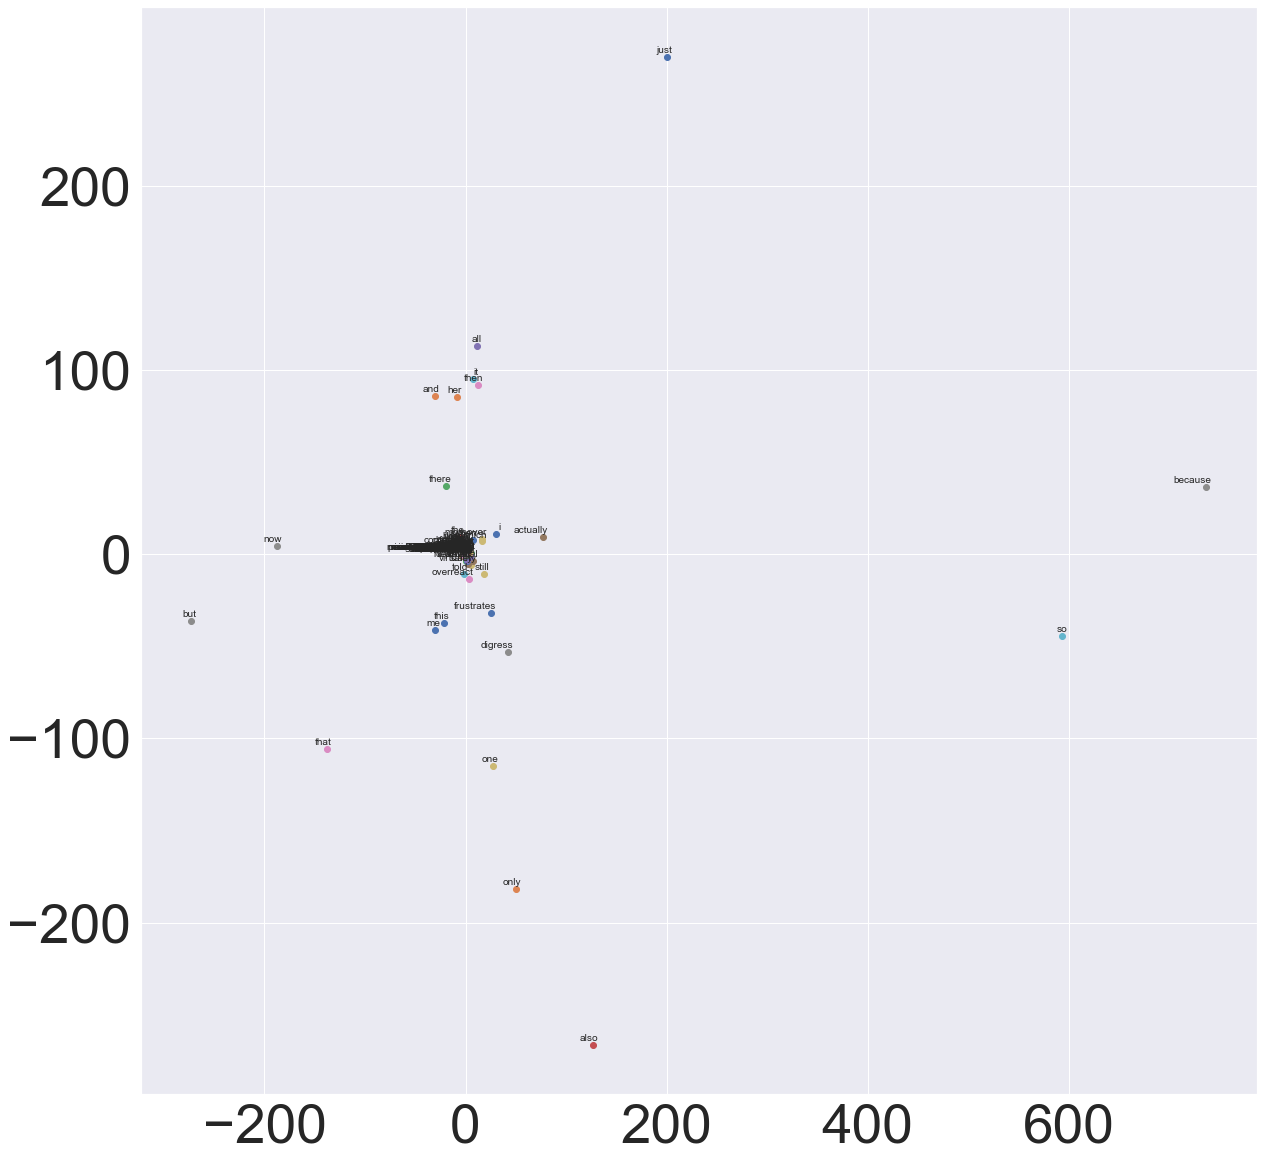

In [190]:
%matplotlib inline
plt.figure(figsize=(15,15) 
tsne_plot(w2v_model)

### Feedback: 

Though we have scraped over 4000 induvidual comments it is clear that this not nearly enough. There are two ways now to attain a good vector representation of the reddit comments.
1) We use Google's pre-trained word-vec model to get a more genralized approch than the current. 
2) The second method is to ramp up the scraping process to scrape an enormous amount of texts.

#### Ramp up the data collection functions: 

In [196]:
def extract_comm_tree_to_df_ramp(id2): #Input a ID of string; returns a df of 
    import reddit_config as r_cnf # setup your config page - for username and password for your respective reddit account
    #Setting up a reddit model
    try:
        reddit = praw.Reddit(client_id='AVu7k513AHb_DSBUp3GPPg',\
                     client_secret='YtLs8QTniQRUZHxjCL1_uUsdvMPiyA', \
                     user_agent='CABD',\
                     username= r_cnf.reddit['accessCode'] ,\
                     password= r_cnf.reddit['secretCode'] )
    except:
        print("Error in accessing redit env")
    
    post = reddit.submission(id=id2)
    Subreddit_com_dict = {
                "score":[],\
                "id":[],\
                "created": [],\
                "com_body":[],\
                "comm_tier1":[],\
                "comm_tier2":[]
                }
    post.comments.replace_more(limit=0)
    comments = post.comments.list()

    for comment in post.comments.list():
        if isinstance(comment, MoreComments):
            continue
        Subreddit_com_dict["score"].append(comment.score)
        Subreddit_com_dict["id"].append(comment.id)
        Subreddit_com_dict["created"].append(comment.created)
        Subreddit_com_dict["com_body"].append(comment.body)
        for reply in comment.replies:
            if isinstance(reply, MoreComments):
                        continue
            Subreddit_com_dict["comm_tier1"].append(reply.body)
            for reply2 in reply.replies:
                    if isinstance(reply2, MoreComments):
                        continue
                    Subreddit_com_dict["comm_tier2"].append(reply2.body)

    Subreddit_com_data = pd.DataFrame.from_dict(Subreddit_com_dict, orient='index').transpose()
    _timestamp = Subreddit_com_data["created"].apply(get_date)
    Subreddit_com_data = Subreddit_com_data.assign(timestamp = _timestamp)
    Subreddit_com_data_1 = Subreddit_com_data.drop(['created'], axis=1)
    return Subreddit_com_data_1 

In [197]:
test = extract_comm_tree_to_df_ramp("m0q5bm")
test
#By changing one line of code in the iteration now we are able to get more comments from a single post 
# refer to refernce 1, where the same ID could only get 122 comments, now we have 496 comments extracted

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,12640,gq998hk,congress DARED him to buy at 40,That’s the best part... “would you buy it at $...,He really should have scrennshared a live stre...,2021-03-08 22:19:59
1,6292,gq97scl,"I am once again telling you, I love this man",And he leveled them - he's a hero. Truly.,Yes or no?,2021-03-08 22:09:25
2,28013,gq98hjm,Your double down at $38 has net you roughly ~7...,If they were smart they took his advice. Like ...,Followed by assholes chuckling in the backgrou...,2021-03-08 22:14:30
3,20682,gq99odc,Doing it once was legendary . But doubling dow...,Can’t call it market manipulation if you are a...,Probably because you are like me and we are bo...,2021-03-08 22:23:14
4,3505,gq97rp4,FUCK YEAH \n\n\nTHE MAN THE MYTH THE LEGEND,There is this warm cozy feeling for a man that...,That congressman did us all a favor. He even a...,2021-03-08 22:09:16
...,...,...,...,...,...,...
492,64,gq9abcl,"IF HE'S STILL IN, I'M STILL IN",None,None,2021-03-08 22:27:55
493,90,gq9at3z,Welcome. You’ve got mail.,None,None,2021-03-08 22:31:35
494,47,gq9pezb,"Expert DD, I'm convinced.",None,None,2021-03-09 00:29:42
495,49,gq9asi4,IF HE'S STILL IN I'M STILL IN!,None,None,2021-03-08 22:31:28


#### Ramping up the Post lvl function to capture n number of posts  

In [215]:
def extract_reddit_post_com_rep_ramp(subreddit_name,n): # Subreddit_name = String 
    import reddit_config as r_cnf # setup your config page - for username and password for your respective reddit account
    #Setting up a reddit model
    reddit = praw.Reddit(client_id='AVu7k513AHb_DSBUp3GPPg', \
                     client_secret='YtLs8QTniQRUZHxjCL1_uUsdvMPiyA', \
                     user_agent='CABD', \
                     username= r_cnf.reddit['accessCode'] , \
                     password= r_cnf.reddit['secretCode'] )
    try:
        GME_subreddit = reddit.subreddit(subreddit_name)
    except:
        print("Error in passing subreddit_name value")
    
    top_subreddit = GME_subreddit.top(limit=1000)
    Subreddit_dict = { "title":[],\
                "score":[],\
                "id":[],\
                "url":[],\
                "comms_num": [],\
                "created": [],\
                "body":[]}
    for submission in top_subreddit:
        Subreddit_dict["title"].append(submission.title)
        Subreddit_dict["score"].append(submission.score)
        Subreddit_dict["id"].append(submission.id)
        Subreddit_dict["url"].append(submission.url)
        Subreddit_dict["comms_num"].append(submission.num_comments)
        Subreddit_dict["created"].append(submission.created)
        Subreddit_dict["body"].append(submission.selftext)
    
    Subreddit_data = pd.DataFrame(Subreddit_dict)
    Subreddit_top_com_id = { "id":[] }
    Top_comm_posts = Subreddit_data['comms_num'].nlargest(n=n)
    for index in Top_comm_posts.index:
           Subreddit_top_com_id["id"].append(Subreddit_data.iloc[index]['id'])
    
    def get_date(created):
        return dt.datetime.fromtimestamp(created)

    _timestamp = Subreddit_data["created"].apply(get_date)
    Subreddit_data = Subreddit_data.assign(timestamp = _timestamp)
    Subreddit_data = Subreddit_data.drop(['created'], axis=1)
    # Top comment containeing reddit post's ID have been obtained 
    # Now to extract the 2 tier comment tree of these posts
    All_Data_Com = pd.DataFrame([])
    for I in range(n):
        print("Current post bieng scraped is %(post)d" % {"post":I})
        Data = extract_comm_tree_to_df_ramp(Subreddit_data['id'][I])

        All_Data_Com = All_Data_Com.append(Data)
    
    
    return Subreddit_data,All_Data_Com;
    

In [216]:
# Scraping the comments from the top 100 posts in GME

In [217]:
Post_GME,All_Data_GME = extract_reddit_post_com_rep_ramp('GME',100)

Current post bieng scraped is 0
Current post bieng scraped is 1
Current post bieng scraped is 2
Current post bieng scraped is 3
Current post bieng scraped is 4
Current post bieng scraped is 5
Current post bieng scraped is 6
Current post bieng scraped is 7
Current post bieng scraped is 8
Current post bieng scraped is 9
Current post bieng scraped is 10
Current post bieng scraped is 11
Current post bieng scraped is 12
Current post bieng scraped is 13
Current post bieng scraped is 14
Current post bieng scraped is 15
Current post bieng scraped is 16
Current post bieng scraped is 17
Current post bieng scraped is 18
Current post bieng scraped is 19
Current post bieng scraped is 20
Current post bieng scraped is 21
Current post bieng scraped is 22
Current post bieng scraped is 23
Current post bieng scraped is 24
Current post bieng scraped is 25
Current post bieng scraped is 26
Current post bieng scraped is 27
Current post bieng scraped is 28
Current post bieng scraped is 29
Current post bieng s

In [218]:
All_Data_GME

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,1,gy49tkt,Edit Edit: [the reddit mash up OP is referring...,It's pretty crazy how much many peoples' opini...,In a single day!,2021-05-14 18:46:49
1,947,gy3en28,Vlady my boi that doesn’t look good for ya!,Would be great if this gained traction.,Yes... yes... just... yes. Please. \n\nPretty ...,2021-05-14 14:55:49
2,424,gy3mqox,If I steal a candy bar I go to jail that day. ...,Why post this shit every day instead of postin...,Let's short robinhood heavily and use profits ...,2021-05-14 16:01:34
3,296,gy3h4os,So glad I transferred out,Soon to fold back to being a boy in Bulgaria.,and the 4 million user pilgrimage to fidelity lol,2021-05-14 15:17:12
4,153,gy3fpsn,Look at that Robincrook,The actual video would look even worse.,My friend has argued RH is good. I tried to ex...,2021-05-14 15:05:11
...,...,...,...,...,...,...
427,1,guctfed,Not true. A big part of trump vs Hillary was t...,None,None,2021-04-13 12:25:10
428,1,gucrzrm,Learn to read. I said nothing about infinite g...,None,None,2021-04-13 12:02:23
429,1,gun8m0v,"Not only are you wrong, you're embarrassingly ...",None,None,2021-04-15 22:17:43
430,1,gu9w11o,Imagine being this dumb.,None,None,2021-04-12 19:10:34


In [219]:
All_Data_GME.shape

(45813, 6)

In [220]:
Post_Gamestop,All_Data_Gamestop = extract_reddit_post_com_rep_ramp('Gamestopstock',100)

Current post bieng scraped is 0
Current post bieng scraped is 1
Current post bieng scraped is 2
Current post bieng scraped is 3
Current post bieng scraped is 4
Current post bieng scraped is 5
Current post bieng scraped is 6
Current post bieng scraped is 7
Current post bieng scraped is 8
Current post bieng scraped is 9
Current post bieng scraped is 10
Current post bieng scraped is 11
Current post bieng scraped is 12
Current post bieng scraped is 13
Current post bieng scraped is 14
Current post bieng scraped is 15
Current post bieng scraped is 16
Current post bieng scraped is 17
Current post bieng scraped is 18
Current post bieng scraped is 19
Current post bieng scraped is 20
Current post bieng scraped is 21
Current post bieng scraped is 22
Current post bieng scraped is 23
Current post bieng scraped is 24
Current post bieng scraped is 25
Current post bieng scraped is 26
Current post bieng scraped is 27
Current post bieng scraped is 28
Current post bieng scraped is 29
Current post bieng s

In [221]:
All_Data_Gamestop

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,6,goqkwur,"Guys I just bought, a lil late but whatever. L...",289 is the number for the day. Let's see if th...,Yes there is im hearing 1000 as well,2021-02-25 19:55:36
1,4,goqryfo,Just bought 4 shares. Lets BUY AND HOLD!!!!!,i hope,"189, apologize.",2021-02-25 20:40:36
2,5,gordjt7,We holding tor tomorrow too friday ending high...,F' em. They've been grouping up and manipulati...,i hope,2021-02-25 23:08:59
3,4,gopug7i,Are we going to hit 400 today?,I don't know if they are dems but **** them,Ok Boss 😂\nWhat platforms do you trade on ?,2021-02-25 16:59:59
4,3,gl5npue,You guys are crazy but smart stupid lmao you g...,Offcourse you hold my beautiful retard,Thanks guys. I just bought 5 new stocks 😁,2021-01-28 23:30:20
...,...,...,...,...,...,...
3,1,gsujabn,What’s going on with amc,None,None,2021-03-30 23:43:17
4,1,gsz0tge,they won. Gamestop keeps going down because of...,None,None,2021-04-01 01:43:03
5,1,gsu2pep,Look at wsb Account,None,None,2021-03-30 21:34:36
6,1,gszs7j5,And.....you may leave.,None,None,2021-04-01 05:53:37


In [222]:
Post_wallstreetbets,All_Data_WSB = extract_reddit_post_com_rep_ramp('wallstreetbets',100)

Current post bieng scraped is 0
Current post bieng scraped is 1
Current post bieng scraped is 2
Current post bieng scraped is 3
Current post bieng scraped is 4
Current post bieng scraped is 5
Current post bieng scraped is 6
Current post bieng scraped is 7
Current post bieng scraped is 8
Current post bieng scraped is 9
Current post bieng scraped is 10
Current post bieng scraped is 11
Current post bieng scraped is 12
Current post bieng scraped is 13
Current post bieng scraped is 14
Current post bieng scraped is 15
Current post bieng scraped is 16
Current post bieng scraped is 17
Current post bieng scraped is 18
Current post bieng scraped is 19
Current post bieng scraped is 20
Current post bieng scraped is 21
Current post bieng scraped is 22
Current post bieng scraped is 23
Current post bieng scraped is 24
Current post bieng scraped is 25
Current post bieng scraped is 26
Current post bieng scraped is 27
Current post bieng scraped is 28
Current post bieng scraped is 29
Current post bieng s

In [223]:
All_Data_WSB

,score,id,com_body,comm_tier1,comm_tier2,timestamp
0,990,gle3n41,Someone needs to open a GameStop across the ny...,We can do it. We own GameStop 💎🙌,Oh.\n\nShit.\n\n🤯,2021-01-30 19:20:13
1,8084,gle2wqt,Bro wtf... 2021 is crazy.,"When the going gets weird, the weird turn pro....","Let me call the CEO Ryan Cohen real quick, I h...",2021-01-30 19:14:38
2,9422,gle1mvf,This is the hype we need for next week!\n\nWE ...,"The writers of 2021 are nuts, really going har...",Look at me. We are the Melvin now.,2021-01-30 19:04:57
3,23366,gle1nwd,This is easily one of the greatest things to h...,Loving this year already,Love Hunter! I've read Fear and Loathing and c...,2021-01-30 19:05:11
4,29343,gle391u,Just when you think this sub can't be any dumb...,2021 is chaotic neutral\n\n2020 was true evil,My favorite author. I’ve seen so many random r...,2021-01-30 19:17:16
...,...,...,...,...,...,...
478,89,glw6m0u,His cousins the muffin man,None,None,2021-02-03 19:52:00
479,7,glw935x,"*""I've got a golden tennndie..""*",None,None,2021-02-03 20:08:09
480,6,glw87hu,AAAAND IT FEELS SO GOOOOOOOOD!!!!!!!!!!!!!!!!!!!!,None,None,2021-02-03 20:02:17
481,19,glwa091,name checks out,None,None,2021-02-03 20:14:22


# Analysis 

Well we can say that the last section of ramping up our scraping to a 'n' number of posts is by far the most important tool developed to take this process much easier in the future of the porject.
For now we will only stick to GME.
The above three subreddit pages are the top pages with respect to GME stock on reddit 

In [224]:
GME_Master_comm = pd.concat([All_Data_GME,All_Data_WSB,All_Data_Gamestop], ignore_index=True)
cols = ['com_body','comm_tier1', 'comm_tier2']
GME_Master_comm['combined'] = GME_Master_comm[cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
GME_Master_comm

,score,id,com_body,comm_tier1,comm_tier2,timestamp,combined
0,1,gy49tkt,Edit Edit: [the reddit mash up OP is referring...,It's pretty crazy how much many peoples' opini...,In a single day!,2021-05-14 18:46:49,Edit Edit: [the reddit mash up OP is referring...
1,947,gy3en28,Vlady my boi that doesn’t look good for ya!,Would be great if this gained traction.,Yes... yes... just... yes. Please. \n\nPretty ...,2021-05-14 14:55:49,"Vlady my boi that doesn’t look good for ya!,Wo..."
2,424,gy3mqox,If I steal a candy bar I go to jail that day. ...,Why post this shit every day instead of postin...,Let's short robinhood heavily and use profits ...,2021-05-14 16:01:34,If I steal a candy bar I go to jail that day. ...
3,296,gy3h4os,So glad I transferred out,Soon to fold back to being a boy in Bulgaria.,and the 4 million user pilgrimage to fidelity lol,2021-05-14 15:17:12,"So glad I transferred out,Soon to fold back to..."
4,153,gy3fpsn,Look at that Robincrook,The actual video would look even worse.,My friend has argued RH is good. I tried to ex...,2021-05-14 15:05:11,"Look at that Robincrook,The actual video would..."
...,...,...,...,...,...,...,...
95776,1,gsujabn,What’s going on with amc,None,None,2021-03-30 23:43:17,"What’s going on with amc,None,None"
95777,1,gsz0tge,they won. Gamestop keeps going down because of...,None,None,2021-04-01 01:43:03,they won. Gamestop keeps going down because of...
95778,1,gsu2pep,Look at wsb Account,None,None,2021-03-30 21:34:36,"Look at wsb Account,None,None"
95779,1,gszs7j5,And.....you may leave.,None,None,2021-04-01 05:53:37,"And.....you may leave.,None,None"


In [234]:
df_GME_M = GME_Master_comm.groupby([GME_Master_comm['timestamp'].dt.date])['combined'].apply(lambda x: ','.join(x)).reset_index()
df_GME_M = pd.DataFrame(data = df_GME_M)
df_GME_M

,timestamp,combined
0,2021-01-26,"Hey r/all,\n\nWelcome to r/wallstreetbets! (WS..."
1,2021-01-27,"[deleted],Listen to this guy. \n\nAt this poin..."
2,2021-01-28,This just makes me more eager to fuck them ove...
3,2021-01-29,"[deleted],Except when it works and they change..."
4,2021-01-30,Someone needs to open a GameStop across the ny...
...,...,...
158,2021-08-07,"Ratio of speculation to data is too high, lock..."
159,2021-08-08,"🍻,#HE QUADRUPLED DOWN,None"
160,2021-08-12,Another free award for this legend. This has b...
161,2021-08-14,"We're slowly approaching the 70 000 awards, th..."


### Back to word-to-vec 

In [250]:
def encode_1(a):
    a = a.encode('utf-8').strip()
    return a

df_GME_M['combined'] = df_GME_M['combined'].apply(encode_1)
df_GME_M['combined'] = df_GME_M['combined'].astype(str)

texts = df_GME_M['combined'].values
print(f'Found {len(texts)} texts.')

# Flatten a list of lists. 
sentences = [s for t in texts for s in sent_tokenize(t)]
print(f'Found {len(sentences)} sentences.')

words_by_sentence = [fast_tokenize(s) for s in sentences]

print('First sentence words:')
print(words_by_sentence[6])

Found 163 texts.
Found 180263 sentences.
Found 180263 sentences after removing blank ones.
First sentence words:
['wtfhexe2x80x99ll', 'break', 'it', 'tomorrowhe', 'didnxe2x80x99t', 'sell']


In [240]:
# Unable to remove stop values due to some error inte UTF type

In [241]:
w2v_model = gensim.models.Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=8)
w2v_model.build_vocab(words_by_sentence, 
                      progress_per=10000)
t = time()
w2v_model.train(words_by_sentence, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.83 mins


In [242]:
w2v_model.save('GME_Second_run.bin')
w2v_model = gensim.models.Word2Vec.load('https://www.dropbox.com/s/1ces56i2xp5bt70/GME_Second_run.bin?raw=1')
w2v_model.wv.most_similar('hold')

[('holding', 0.4320574700832367),
 ('held', 0.3636821508407593),
 ('take', 0.29660436511039734),
 ('bring', 0.28199684619903564),
 ('shake', 0.2806847393512726),
 ('keep', 0.2804867923259735),
 ('stick', 0.2735867202281952),
 ('cheek', 0.25593772530555725),
 ('shove', 0.2556290626525879),
 ('save', 0.25332701206207275)]

In [249]:
w2v_model.wv.most_similar('stock')

[('receipts', 0.3307390809059143),
 ('kiosk', 0.2948116064071655),
 ('shipped', 0.28550130128860474),
 ('craft', 0.2833833694458008),
 ('product', 0.28260788321495056),
 ('cheapest', 0.27696287631988525),
 ('desktop', 0.2744956910610199),
 ('production', 0.2720423638820648),
 ('copies', 0.2667640149593353),
 ('plates', 0.26480817794799805)]

## T -SNE  

t-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.



In [252]:
keys = ['buy','sell','price','hold','stock','crash','cash','money','trade','market']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [253]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<IPython.core.display.Javascript object>


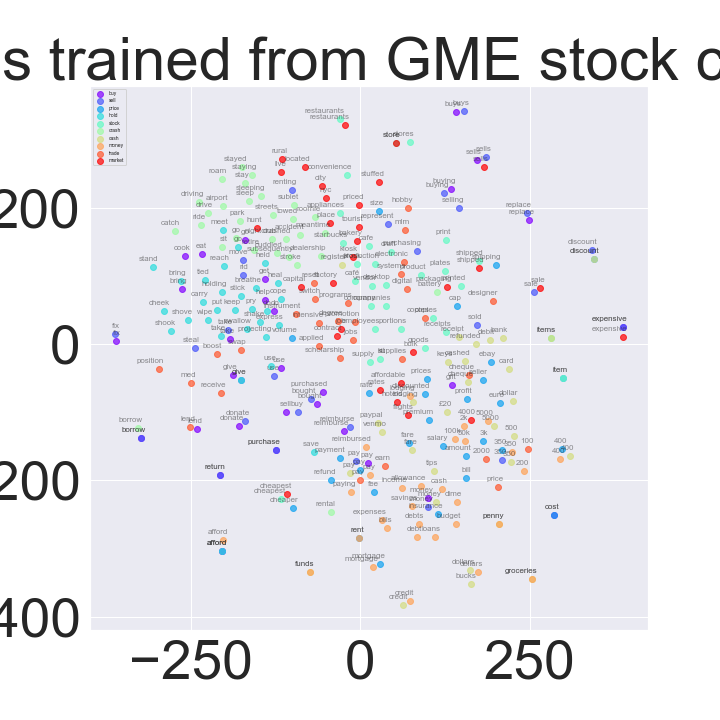

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

In [272]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm



def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(10, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 5),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=2, prop={'size': 5})
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words trained from GME stock conversations', keys, embeddings_en_2d, word_clusters, 0.7,
                        'GME_stock.png')

<IPython.core.display.Javascript object>


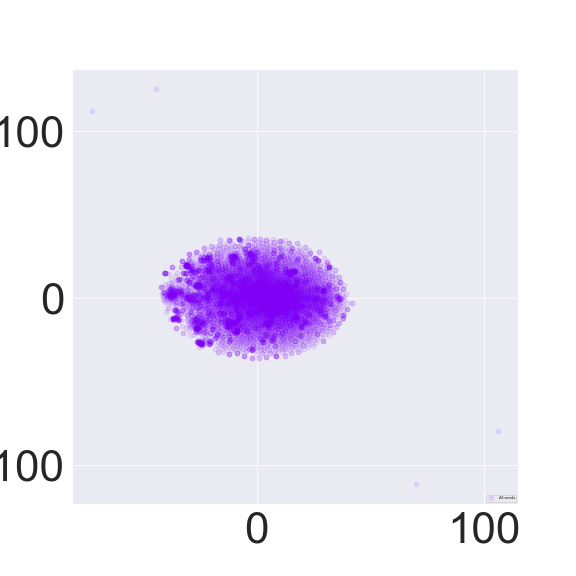

In [293]:
%matplotlib notebook
words_ak = []
embeddings_ak = []
for word in list(w2v_model.wv.index_to_key):
    embeddings_ak.append(w2v_model.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(10, 10))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4, prop={'size': 5})
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('All words', embeddings_ak_2d, a=0.1)

# Conclusion 

From the neighbouring graph within the GME community we can see some intresting patterns,
Where words such as stock and hold are mixed together, which showcase an intresting outcome that, it is possible to find some patterns within such small communities containing less data as well.

More Robust method needs to be developed to capture such patterns in other such meme stocks and analyze them and if diffrent patterns emerge between meme and normal stocks, this could prove to be an intresting find.